# Inferencia Bayesiana Entrega 2: Matias Moran LU 806/19

## Ejercicio 1

Supongamos que uno tiene una variable aleatoria Y que puede modelar con una distribucion
geométrica. Es decir que $P(Y = y | \theta) = \theta (1—\theta)^{y-1}$ para $y \in \{ 1,2,3,.. \}.$ Se utiliza un prior
$\Beta(a, b)$ para $\theta$.

### A) Qué situacion se representa con una variable aleatoria geométrica?

La variable aleatoria geometrica se usa para representar una distribucion similar a la binomial pero donde queremos saber "Cuantos experimentos de bernoulli con probabilidad p de exito tengo que hacer hasta obtener un exito".

por ejemplo cuantas monedas tengo que tirar hasta sacar cara, cuantos dados tengo que tirar hasta que salga un 3, etc

### B) Derivar la distribucion posterior para $\theta$ suponiendo que se observé $Y = y$. Identificar la distribucion encontrada y sus parametros.

$$P(\theta | Y = y) = \frac{P(Y = y| \theta) \cdot L(\theta)}{P(Y = y)}$$

$$P(\theta | Y = y) = \frac{f(\theta) \cdot f(\theta | Y = y)}{P(Y = y)}$$

$$P(\theta | Y = y) = \frac{f(\theta) \cdot (1-\theta)^{y-1} \cdot \theta}{P(Y = y)}$$

$$P(\theta | Y = y) \propto f(\theta) \cdot (1-\theta)^{y-1} \cdot \theta$$

Vemos que la forma $(1-\theta)^{y-1} \cdot \theta$ se asemeja mucho a la pdf de la Beta, asi que vamos a probar un prior $\Beta(a,b)$

$$P(\theta | Y = y) \propto (1-\theta)^{b-1} \cdot \theta^{a-1} \cdot (1-\theta)^{y-1} \cdot \theta$$

$$P(\theta | Y = y) \propto (1-\theta)^{b+y-2} \cdot \theta^{a}$$

$$P(\theta | Y = y) \propto B(a + 1, b + y - 1)$$

> **_NOTA:_**
La razon porque la geometrica es tambien una distribucion conjugada de la Beta es porque es un "caso particular" de la distribucion binomial para k=1 (exitos igual a 1) y donde en vez de multiplicarlo por el numero de posibles permutaciones $\binom{n}{1}$ simplemente se omite esta constante porque el exito siempre esta en la ultima posicion y como esto es una constante se va cuando normalizamos la posterior ya que sigue siendo proporcional

### C) El modelo Beta es un prior conjugado de la Geométrica?

Si, vimos que si tenemos un prior beta y nuestra distribucion es geometrica nuestro post tambien es Beta, asi que es un prior conjugado

## Ejercicio 2

Identificar una pregunta que se pueda responder con un modelo de regresion lineal con
$\beta_{0}. \beta_{1} ,\sigma$ como parametros a estimar. Por ejemplo puede ser, altura del hijo en funcion de
altura de la madre, velocidad maxima de un auto en funcion de caballos de fuerza, etc.
Usatus propios datos o simulalos.

$$Y_{i} \sim \mathcal{N}(\mu(x_{i}), \sigma^{2})$$

$$\mu = \beta_{0} + \beta_{1} \cdot x_{i}$$


> **_DATASETS:_**
El dataset que vamos a utilizar es la informacion de alquiler de bicicletas en Washinton DC en funcion de la temperatura, este es un ejemplo del capitulo 9 del libro de Bayes rules.

### Setup

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import concurrent.futures as theads_futures
import pymc as pm
import seaborn as sns

from scipy.stats import beta, norm, expon
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from IPython.display import Markdown

np.random.seed(42)
logging.basicConfig(level=logging.INFO)

In [143]:
#https://www.kaggle.com/datasets/marklvl/bike-sharing-dataset?resource=download
df_bikes = pd.read_csv('../../sandbox/bikes/day.csv')

# temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
#unormalize temperatures
df_bikes.temp = (39 - (-8)) * df_bikes.temp + (-8)
df_bikes

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,8.175849,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,9.083466,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,1.229108,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,1.400000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,2.666979,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,3.945849,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,3.906651,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,3.906651,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,4.024151,0.231700,0.483333,0.350754,364,1432,1796


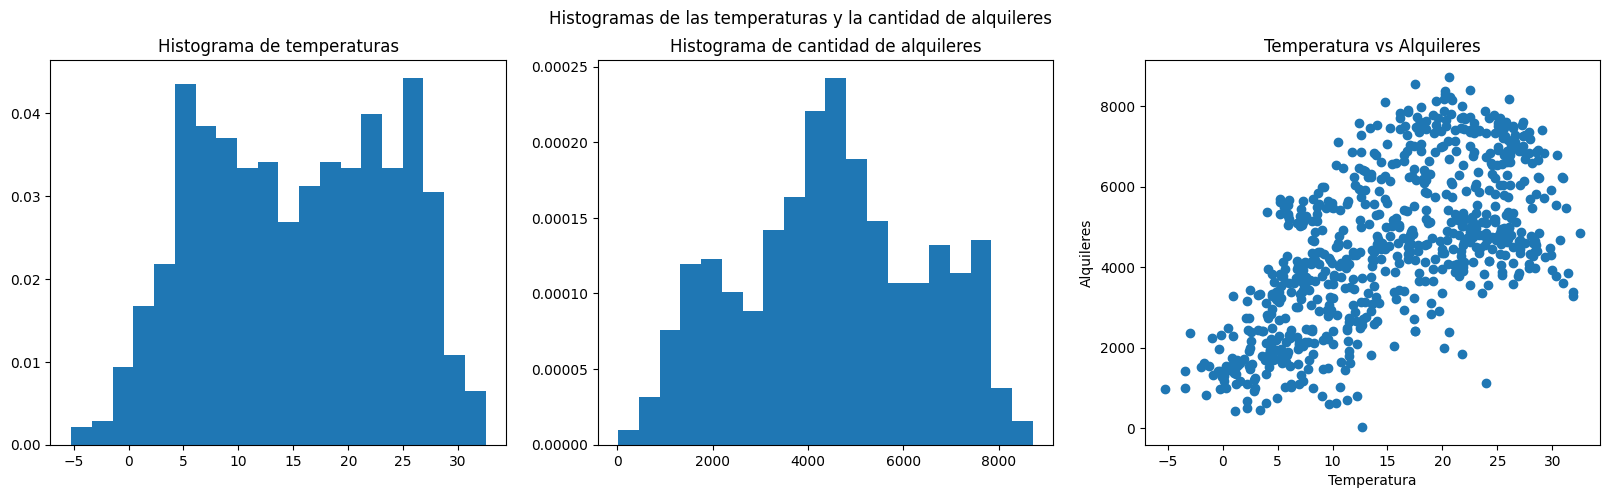

In [4]:
bins_n=20

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Histogramas de las temperaturas y la cantidad de alquileres')

ax[0].plot()
ax[0].set_title('Histograma de temperaturas')
ax[0].hist(df_bikes.temp, bins=bins_n, density=True)

ax[1].plot()
ax[1].set_title('Histograma de cantidad de alquileres')
ax[1].hist(df_bikes.cnt, bins=bins_n, density=True)

ax[2].plot()
ax[2].set_title('Temperatura vs Alquileres')
ax[2].scatter(df_bikes.temp, df_bikes.cnt)
ax[2].set_xlabel('Temperatura')
ax[2].set_ylabel('Alquileres')

plt.show()

### A) Proponer priors para $\beta_{0}. \beta_{1} ,\sigma$

Para el caso de las bicicletas vamos a basarnos en el libro de bayes rules y vamos a hacer la regresion de temperatura vs cantidad de bicicletas alquiladas diarias poniendo priors normales a los parametros de la relacion lineal y un parametro exponencial para sigma para limitar el rango a que solo sea de valores positivos

$$
\text{data:} \quad Y_{i}|\beta_{0}, \beta_{1} ,\sigma \sim \mathcal{N}(\mu_{i}, \sigma^{2}) \quad  \text{with} \quad  \mu(x_{i}) = \beta_{0} + \beta_{1} \cdot X_{i}
$$

$$
\text{priors:} \quad \beta_{0} \sim \mathcal{N}(m_{0}, s^{2}_{0})
$$
$$
\quad \quad \quad \quad \beta_{1} \sim \mathcal{N}(m_{1}, s^{2}_{1})
$$
$$
\quad \quad \quad \sigma \sim Exp(l)
$$

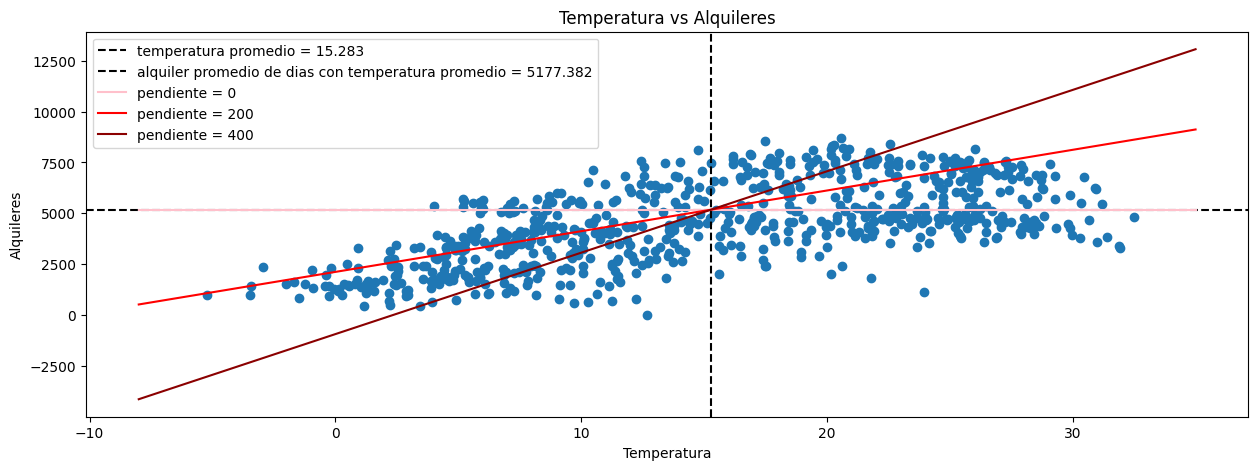


Para el caso de las bicicletas, podemos ver:

- en un dia promedio de 15.283 de temperatura, El alquier de bicicletas es de 5177.382 con una desviacion de hasta 1817 y 8555
esto nos dice que $\beta_{0} \sim \mathcal{N}(5177.382, 3000^{2})$ donde estamos centrando los datos en en el origen como lo indican las lineas punteadas negras

- por cada aumento de 5 en el valor de la temperatura la cantidad de bicicletas alquiladas sube en 200 aproximadamente y esto puede variar entre a lo sumo 0 y 400 como lo representan las rectas marcadas en rojo, esto nos dice que $\beta_{1} \sim \mathcal{N}(200, 200^{2})$ es una distribucion razonable

- en un dia cualquiera cantidad de alquileres tiene una rango que puede ser de $\pm$ 3000 alquileres como sabemos que 3 desviaciones estandard deberia contener a casi todos los datos deducimos que la desviacion estandar es de $\frac{3000}3 = 1000$<br>.
esto nos dice que podemos modelar nuestro $\sigma$ para que su expected value sea 1000.<br>
$E(\sigma) = \frac{1}{l} = 1000 \implies l = 0.001$


Finalmente tenemos los priors:


$$
\text{data:} \quad Y_{i}|\beta_{0}, \beta_{1} ,\sigma \sim \mathcal{N}(\mu_{i}, \sigma^{2}) \quad  \text{with} \quad  \mu(x_{i}) = \beta_{0} + \beta_{1} \cdot X_{i}
$$

$$
\text{priors:} \quad \beta_{0} \sim \mathcal{N}(5177.382, 3000^{2})
$$
$$
\quad \quad \quad \quad \beta_{1} \sim \mathcal{N}(200, 200^{2})
$$
$$
\quad \quad \quad \sigma \sim Exp(0.001)
$$



In [5]:
bins_n=20

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.set_title('Temperatura vs Alquileres')
ax.scatter(df_bikes.temp, df_bikes.cnt)
ax.set_xlabel('Temperatura')
ax.set_ylabel('Alquileres')

# Calculamos la temperatura media y la media de la cantidad de bicicletas alquiladas en ese dia para los datos que tienen una temperatura cercana a la media
mean_temperature = round(df_bikes.temp.mean(), 3)
average_temperature_samples = df_bikes[np.isclose(df_bikes.temp, np.full_like(df_bikes.temp, mean_temperature), atol= np.full_like(df_bikes.temp, 2.5))]
mean_rides = round(average_temperature_samples.cnt.mean(), 3)

ax.axvline(x=mean_temperature, color='black', linestyle='--', label=f'temperatura promedio = {mean_temperature}')
ax.axhline(y=mean_rides, color='black', linestyle='--', label=f'alquiler promedio de dias con temperatura promedio = {mean_rides}')


x = np.linspace(-8, 35, 400)
y = 0/5 * (x - mean_temperature) + mean_rides
plt.plot(x, y, label='pendiente = 0', color='pink')
y = 1000/5 * (x - mean_temperature) + mean_rides
plt.plot(x, y, label='pendiente = 200', color='red')
y = 2000/5 * (x - mean_temperature) + mean_rides
plt.plot(x, y, label='pendiente = 400', color='darkred')


ax.legend()
plt.show()


Markdown(fr"""
Para el caso de las bicicletas, podemos ver:

- en un dia promedio de {mean_temperature} de temperatura, El alquier de bicicletas es de {mean_rides} con una desviacion de hasta {average_temperature_samples.cnt.min()} y {average_temperature_samples.cnt.max()}
esto nos dice que $\beta_{{0}} \sim \mathcal{{N}}({mean_rides}, 3000^{{2}})$ donde estamos centrando los datos en en el origen como lo indican las lineas punteadas negras

- por cada aumento de 5 en el valor de la temperatura la cantidad de bicicletas alquiladas sube en 200 aproximadamente y esto puede variar entre a lo sumo 0 y 400 como lo representan las rectas marcadas en rojo, esto nos dice que $\beta_{{1}} \sim \mathcal{{N}}(200, 200^{{2}})$ es una distribucion razonable

- en un dia cualquiera cantidad de alquileres tiene una rango que puede ser de $\pm$ 3000 alquileres como sabemos que 3 desviaciones estandard deberia contener a casi todos los datos deducimos que la desviacion estandar es de $\frac{{3000}}{3} = 1000$<br>.
esto nos dice que podemos modelar nuestro $\sigma$ para que su expected value sea 1000.<br>
$E(\sigma) = \frac{{1}}{{l}} = 1000 \implies l = {round(1/1000, 6)}$


Finalmente tenemos los priors:


$$
\text{{data:}} \quad Y_{{i}}|\beta_{{0}}, \beta_{{1}} ,\sigma \sim \mathcal{{N}}(\mu_{{i}}, \sigma^{{2}}) \quad  \text{{with}} \quad  \mu(x_{{i}}) = \beta_{{0}} + \beta_{{1}} \cdot X_{{i}}
$$

$$
\text{{priors:}} \quad \beta_{{0}} \sim \mathcal{{N}}({mean_rides}, 3000^{{2}})
$$
$$
\quad \quad \quad \quad \beta_{{1}} \sim \mathcal{{N}}(200, 200^{{2}})
$$
$$
\quad \quad \quad \sigma \sim Exp({round(1/1000, 6)})
$$

""")


In [6]:
beta_0_mean = mean_rides
beta_0_std = 3000

beta_1_mean = 200
beta_1_std = 200

sigma_scale = 1000

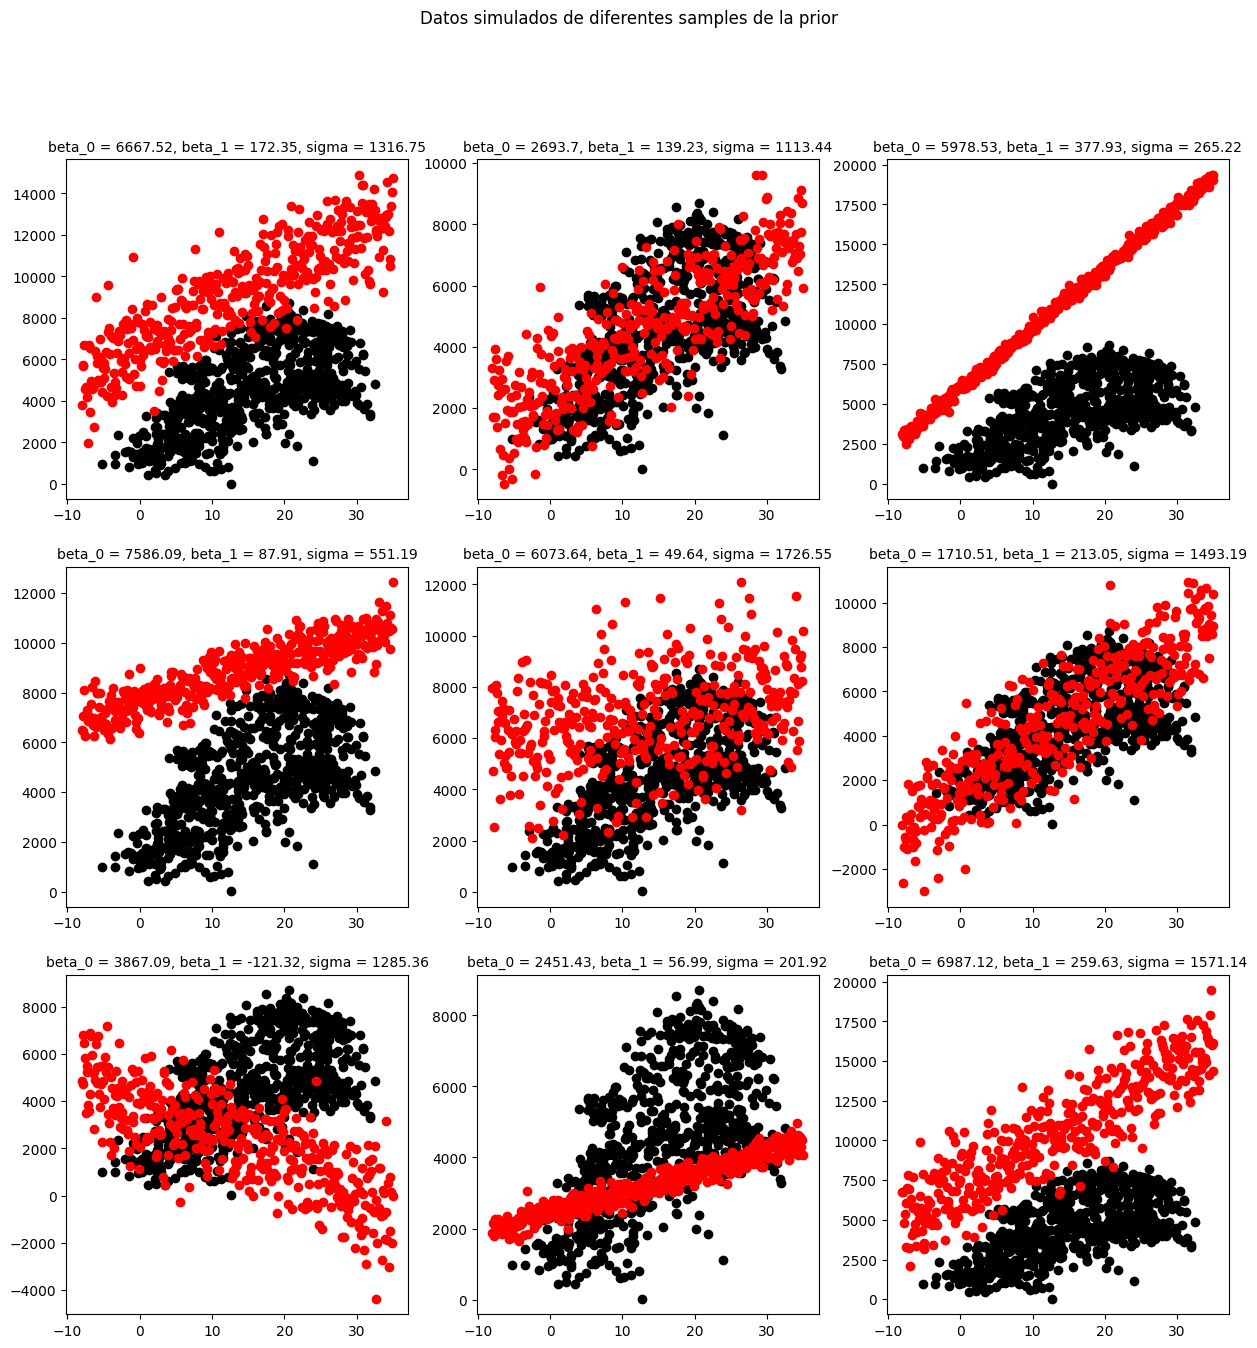



#### Podemos ver que los datos simulados con los priors propuestos son razonables, por lo que procedemos a hacer el posterior predictive



In [7]:
# Hacemos un prior predictive para ver si los priors son razonables

_, ax = plt.subplots(3, 3, figsize=(15, 15))
for k in range(3):
    for i in range(3):
        beta_0 = np.random.normal(beta_0_mean, beta_0_std)
        beta_1 = np.random.normal(beta_1_mean, beta_1_std)
        sigma = expon.rvs(scale=sigma_scale)
        y = beta_0 + beta_1 * x + norm.rvs(scale=sigma, size=x.shape)
        ax[k, i].scatter(df_bikes.temp.values, df_bikes.cnt.values, label='datos reales', color='black')
        ax[k, i].scatter(x, y, label='datos generados', color='red')
        ax[k, i].set_title(f'beta_0 = {round(beta_0, 2)}, beta_1 = {round(beta_1, 2)}, sigma = {round(sigma, 2)}', fontsize=10)

plt.suptitle('Datos simulados de diferentes samples de la prior')
plt.show()


Markdown(fr"""

#### Podemos ver que los datos simulados con los priors propuestos son razonables, por lo que procedemos a hacer el posterior predictive

""")

## B) Escribir la likelihood de los datos de forma analitica en funcion de los parametros.

La Likehood de los parametros en funcion de los datos $\overrightarrow{y} = (y_{1},y_{2},...,y_{n})$ se puede definir como $L(\beta_{{0}}, \beta_{{1}} ,\sigma|\overrightarrow{y}) = f(\overrightarrow{y}|\beta_{{0}}, \beta_{{1}} ,\sigma) = \prod_{i=1}^{n} f(y_{i}|\beta_{{0}}, \beta_{{1}} ,\sigma)$

## C) Implementar el algoritmo de Metropolis (MCMC) y generar 5.000 samples del posterior sin descontar el tramo inicial de la cadena (burn = 0).

In [8]:
def metropolis_hasting(log_posterior, proposal_function, initial_candidate, num_samples):
    result_chain = np.zeros(shape=(num_samples, len(initial_candidate)))
    result_chain[0] = initial_candidate

    for i in range(1, num_samples):

        next_candidate = proposal_function(result_chain[i-1])
        log_acceptance_ratio = log_posterior(next_candidate) - log_posterior(result_chain[i-1])

        if log_acceptance_ratio >= 0:
            result_chain[i] = next_candidate
            continue

        if np.log(np.random.rand()) < log_acceptance_ratio:
            result_chain[i] = next_candidate
        else:
            result_chain[i] = result_chain[i-1]
    
    return result_chain

# hacemos que el siguiente candidato sea normalmente distribuido con media = current_candidate y desviacion = std ya que a lo sumo puede caer en [current_candidate - 3*std, current_candidate + 3*std]
# en la mayoria de los casos (3 desviaciones estadard).
# para beta_0, beta_1 y sigma elegimos std de dos ordenes de magnitud mas chicos
def bikes_normal_proposal(current_candidate):
    new_beta_0 = np.random.normal(current_candidate[0], 50)
    new_beta_1 = np.random.normal(current_candidate[1], 5)
    new_sigma = np.random.normal(current_candidate[2], 50)
    return [new_beta_0, new_beta_1, new_sigma]

def bikes_log_posterior_unnormalize(candidate):
    log_prior = np.log(norm.pdf(candidate[0], beta_0_mean, beta_0_std)) + np.log(norm.pdf(candidate[1], beta_1_mean, beta_1_std)) + np.log(expon.pdf(candidate[2], scale=sigma_scale))

    temps = df_bikes['temp'].values
    cnts = df_bikes['cnt'].values
    
    predicted = candidate[0] + candidate[1] * temps
    
    log_likehoods = np.log(norm.pdf(cnts, predicted, candidate[2]))

    log_likehood = np.sum(log_likehoods)

    return log_prior + log_likehood

In [9]:
bike_chain_1 = metropolis_hasting(bikes_log_posterior_unnormalize, bikes_normal_proposal, [beta_0_mean, beta_1_mean, sigma_scale], 5000)
bike_chain_1

array([[5177.382     ,  200.        , 1000.        ],
       [5177.382     ,  200.        , 1000.        ],
       [5194.41470682,  203.65690126, 1029.52110306],
       ...,
       [2483.13726268,  133.99236463, 1540.27104492],
       [2483.13726268,  133.99236463, 1540.27104492],
       [2483.13726268,  133.99236463, 1540.27104492]])

## D) Graficar la cadena resultante (en 3d para todo el posterior o independientemente para cada parametro en 3 graficos distintos). Parece haber convergido la cadena?

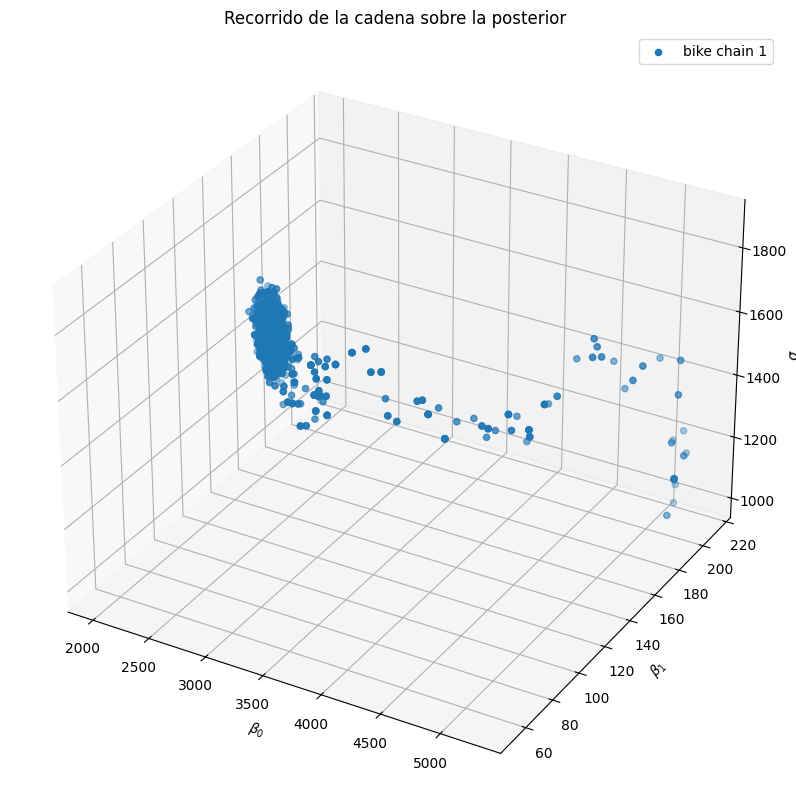



#### La cadena parece haber convergido y estabilizado



In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(bike_chain_1[:, 0], bike_chain_1[:, 1], bike_chain_1[:, 2], label='bike chain 1')

ax.set_xlabel(r'$\beta_{0}$')
ax.set_ylabel(r'$\beta_{1}$')
ax.set_zlabel(r'$\sigma$')
ax.set_title('Recorrido de la cadena sobre la posterior')

ax.legend()
plt.show()


Markdown(fr"""

#### La cadena parece haber convergido y estabilizado

""")

## E) Repetir el inciso c) y d) para 3 cadenas paralelas. Grafiquelas superpuestas con colores distintos. Cuantos samples tarda en llegar a estado de equilibrio (a ojo)?

In [11]:
arguments = [
    (bikes_log_posterior_unnormalize, bikes_normal_proposal, [1000, 60, 1000], 5000),
    (bikes_log_posterior_unnormalize, bikes_normal_proposal, [1000, 200, 1800], 5000),
    (bikes_log_posterior_unnormalize, bikes_normal_proposal, [5000, 60, 1000], 5000),
    (bikes_log_posterior_unnormalize, bikes_normal_proposal, [5000, 200, 1000], 5000),
]

with theads_futures.ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(metropolis_hasting, *args) for args in arguments]
    theads_futures.wait(futures)
    bike_chains = [future.result() for future in futures]

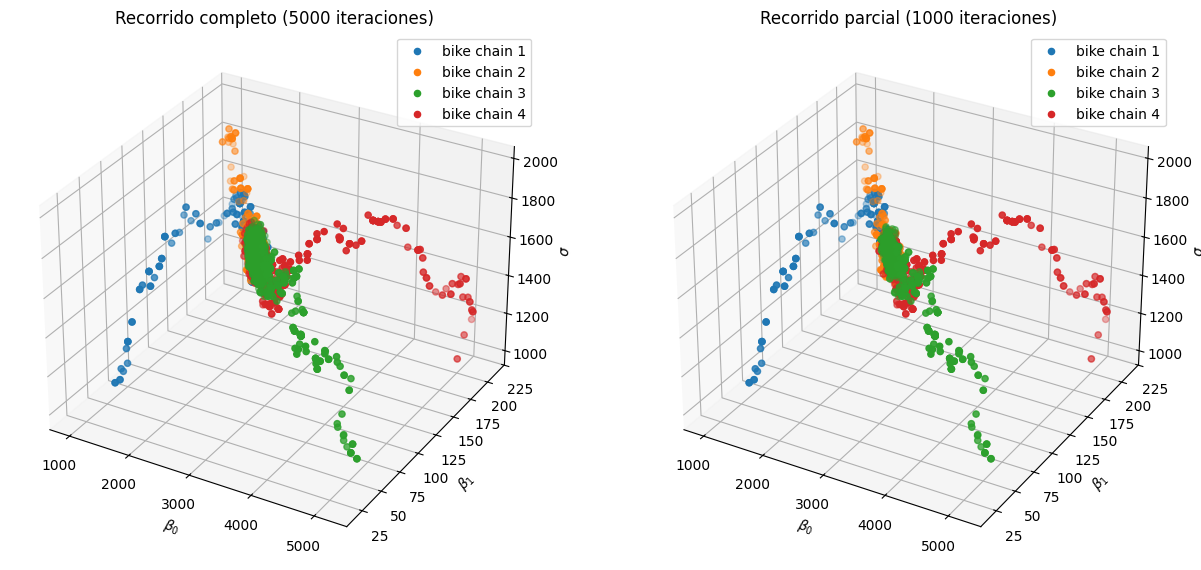



#### Vemos que las cadenas se mezclan y se estabilizan a partir de las 1000 iteraciones aproximadamente



In [12]:
fig = plt.figure(figsize=(15,15))

ax0 = fig.add_subplot(121, projection='3d')

ax0.scatter(bike_chains[0][:, 0], bike_chains[0][:, 1], bike_chains[0][:, 2], label='bike chain 1')
ax0.scatter(bike_chains[1][:, 0], bike_chains[1][:, 1], bike_chains[1][:, 2], label='bike chain 2')
ax0.scatter(bike_chains[2][:, 0], bike_chains[2][:, 1], bike_chains[2][:, 2], label='bike chain 3')
ax0.scatter(bike_chains[3][:, 0], bike_chains[3][:, 1], bike_chains[3][:, 2], label='bike chain 4')

ax0.set_xlabel(r'$\beta_{0}$')
ax0.set_ylabel(r'$\beta_{1}$')
ax0.set_zlabel(r'$\sigma$')
ax0.set_title('Recorrido completo (5000 iteraciones)')

ax0.legend()

ax1 = fig.add_subplot(122, projection='3d')

mc_convergence_iterations = 1000

ax1.scatter(bike_chains[0][:mc_convergence_iterations, 0], bike_chains[0][:mc_convergence_iterations, 1], bike_chains[0][:mc_convergence_iterations, 2], label='bike chain 1')
ax1.scatter(bike_chains[1][:mc_convergence_iterations, 0], bike_chains[1][:mc_convergence_iterations, 1], bike_chains[1][:mc_convergence_iterations, 2], label='bike chain 2')
ax1.scatter(bike_chains[2][:mc_convergence_iterations, 0], bike_chains[2][:mc_convergence_iterations, 1], bike_chains[2][:mc_convergence_iterations, 2], label='bike chain 3')
ax1.scatter(bike_chains[3][:mc_convergence_iterations, 0], bike_chains[3][:mc_convergence_iterations, 1], bike_chains[3][:mc_convergence_iterations, 2], label='bike chain 4')

ax1.set_xlabel(r'$\beta_{0}$')
ax1.set_ylabel(r'$\beta_{1}$')
ax1.set_zlabel(r'$\sigma$')
ax1.set_title(f'Recorrido parcial ({mc_convergence_iterations} iteraciones)')

ax1.legend()

plt.show()


Markdown(fr"""

#### Vemos que las cadenas se mezclan y se estabilizan a partir de las {mc_convergence_iterations} iteraciones aproximadamente

""")

## F) Elija al azar 100 samples del posterior y grafique las 100 rectas correspondientes superpuestas a los datos.

In [13]:
# nos quedamos con los 4000 samples de cada cadena evitando tomar los 1000 primeros de burn de cada una
bike_final_chain = np.concatenate([bike_chains[0][mc_convergence_iterations:], bike_chains[1][mc_convergence_iterations:], bike_chains[2][mc_convergence_iterations:], bike_chains[3][mc_convergence_iterations:]])
bike_final_chain.shape

(16000, 3)

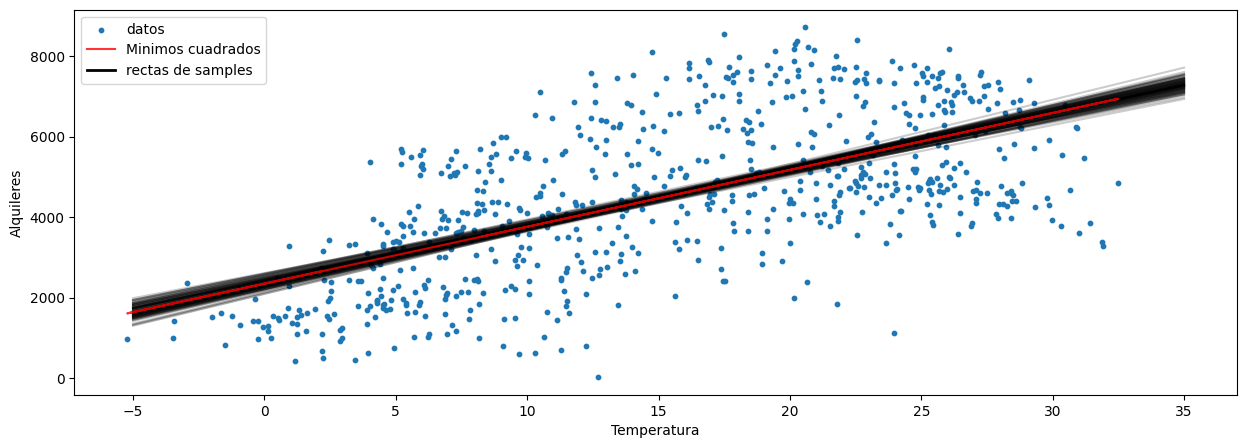



#### Vemos que las rectas de la posterior tienden a centrarse a la recta de minimos cuadrados y que algunas de las rectas factibles tienen una pendiente mas baja y un intercepto mas alta



In [14]:
bikes_100_posteriors = bike_final_chain[np.random.choice(bike_final_chain.shape[0], 100, replace=False)]

plt.figure(figsize=(15, 5))

plt.scatter(df_bikes.temp, df_bikes.cnt, s=10, label = 'datos')

x = np.linspace(-5, 35, 100)

for i in range(len(bikes_100_posteriors)):
    plt.plot(x, bikes_100_posteriors[i, 0] + bikes_100_posteriors[i, 1] * x, color = 'black', alpha=0.2)

regression_line = np.polyval(np.polyfit(df_bikes.temp, df_bikes.cnt, 1), df_bikes.temp)
plt.plot(df_bikes.temp, regression_line, color='red', alpha= 0.8, label = 'Minimos cuadrados')


handles, labels = plt.gca().get_legend_handles_labels()
legend_item = Line2D([0], [0], label='rectas de samples', color='black', lw=2)
handles.append(legend_item)
plt.legend(handles=handles, labels=labels + ['rectas de samples'])

plt.xlabel('Temperatura')
plt.ylabel('Alquileres')
plt.show()



Markdown(fr"""

#### Vemos que las rectas de la posterior tienden a centrarse a la recta de minimos cuadrados y que algunas de las rectas factibles tienen una pendiente mas baja y un intercepto mas alta

""")

## G) Genere una distribucion posterior predictive para Y con algun X fijo. Utilicela para responder alguna pregunta relevante a sus datos.


### Cual es la probabilidad de que un dia de 20 grados tenga mas de 6000 alquileres de bicicletas?

In [15]:
# obtenemos 5000 samples de la posterior
bikes_5000_posteriors = bike_final_chain[np.random.choice(bike_final_chain.shape[0], 5000, replace=False)]

days_with_more_than_6000_rides = 0

for k in range(len(bikes_5000_posteriors)):
    posterior_sample = bikes_5000_posteriors[k]
    temperature_predicted = np.random.normal(posterior_sample[0] + posterior_sample[1] * 20, posterior_sample[2], 1)
    if temperature_predicted > 6000:
        days_with_more_than_6000_rides += 1


Markdown(fr"""

### La probabilidad de que el tiempo de alquiler de bicicletas sea mayor a 6000 es de {days_with_more_than_6000_rides/len(bikes_5000_posteriors)}.

""")




### La probabilidad de que el tiempo de alquiler de bicicletas sea mayor a 6000 es de 0.2888.



### Cuantos alquileres de bicis voy a tener en un dia de 25 grados?

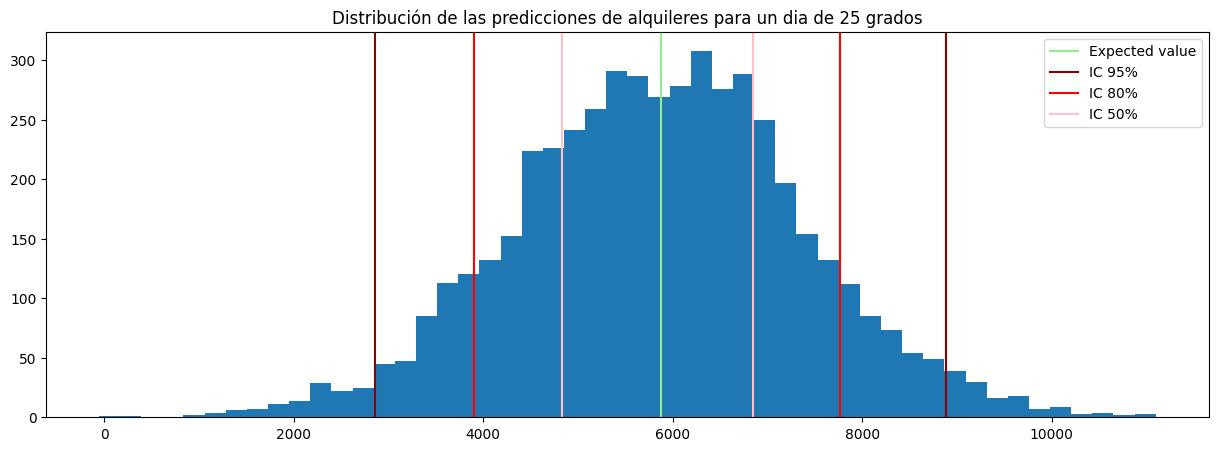



#### El expected value de un dia de 25 grados es de 5878.942984511472
#### El intervalo de credibilidad del 50% es de (4835.094515489107, 6851.229941470964)
#### El intervalo de credibilidad del 80% es de (3903.3868998084995, 7763.012492113769)
#### El intervalo de credibilidad del 95% es de (2860.7617589379365, 8881.819442022044)



In [16]:
MH_temperatures_predicted = np.array([])

for k in range(len(bikes_5000_posteriors)):
    posterior_sample = bikes_5000_posteriors[k]
    temperature_predicted = np.random.normal(posterior_sample[0] + posterior_sample[1] * 25, posterior_sample[2], 1)
    MH_temperatures_predicted = np.append(MH_temperatures_predicted, temperature_predicted)

plt.figure(figsize=(15, 5))

plt.title('Distribución de las predicciones de alquileres para un dia de 25 grados')

plt.hist(MH_temperatures_predicted, bins=50)

percentil_50 = np.percentile(MH_temperatures_predicted, 50)
percentil_2_5 = np.percentile(MH_temperatures_predicted, 2.5)
percentil_10 = np.percentile(MH_temperatures_predicted, 10)
percentil_25 = np.percentile(MH_temperatures_predicted, 25)
percentil_75 = np.percentile(MH_temperatures_predicted, 75)
percentil_90 = np.percentile(MH_temperatures_predicted, 90)
percentil_97_5 = np.percentile(MH_temperatures_predicted, 97.5)

plt.axvline(percentil_50, color = 'lightgreen', label = 'Expected value')

plt.axvline(percentil_2_5, color = 'darkred')
plt.axvline(percentil_97_5, color = 'darkred', label = 'IC 95%')

plt.axvline(percentil_10, color = 'red')
plt.axvline(percentil_90, color = 'red', label = 'IC 80%')

plt.axvline(percentil_25, color = 'pink')
plt.axvline(percentil_75, color = 'pink', label = 'IC 50%')

plt.legend()
plt.show()

Markdown(fr"""

#### El expected value de un dia de 25 grados es de {percentil_50}
#### El intervalo de credibilidad del 50% es de ({percentil_25}, {percentil_75})
#### El intervalo de credibilidad del 80% es de ({percentil_10}, {percentil_90})
#### El intervalo de credibilidad del 95% es de ({percentil_2_5}, {percentil_97_5})

""")


# Ejercicio 3

Para los mismos datos, mismo modelo y mismos priors del ejercicio 2, haga la regresion
lineal utilizando brms o un paquete similar.



## A) Grafique, utilizando el paquete, las cadenas marginales. Parecen haber convergido?


In [17]:

with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    beta_0 = pm.Normal("beta_0", beta_0_mean, sigma=beta_0_std)
    beta_1 = pm.Normal("beta_1", beta_1_mean, sigma=beta_1_std)
    sigma = pm.Exponential("sigma", scale=sigma_scale)

    # Define likelihood
    likelihood = pm.Normal("y", mu=beta_0 + beta_1 * df_bikes.temp.values, sigma=sigma, observed=df_bikes.cnt.values)

    # Inference!
    # draw 5000 posterior samples using NUTS sampling
    idata = pm.sample(5000, chains = 4)
    

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta_0, beta_1, sigma]
INFO:pymc.sampling.mcmc:NUTS: [beta_0, beta_1, sigma]


/home/matias/Database/files/Vault/files/Repos/UBA/EstimacionBayesiana/.venv/lib/python3.12/site-packages/rich/live.
py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.


In [18]:
idata.posterior

<xarray.Dataset> Size: 520kB
Dimensions:  (chain: 4, draw: 5000)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40kB 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
Data variables:
    beta_0   (chain, draw) float64 160kB 2.233e+03 2.301e+03 ... 2.338e+03
    beta_1   (chain, draw) float64 160kB 146.4 145.2 146.5 ... 147.9 148.3 136.5
    sigma    (chain, draw) float64 160kB 1.574e+03 1.468e+03 ... 1.519e+03
Attributes:
    created_at:                 2024-10-05T16:14:39.475804+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              18.54385209083557
    tuning_steps:               1000

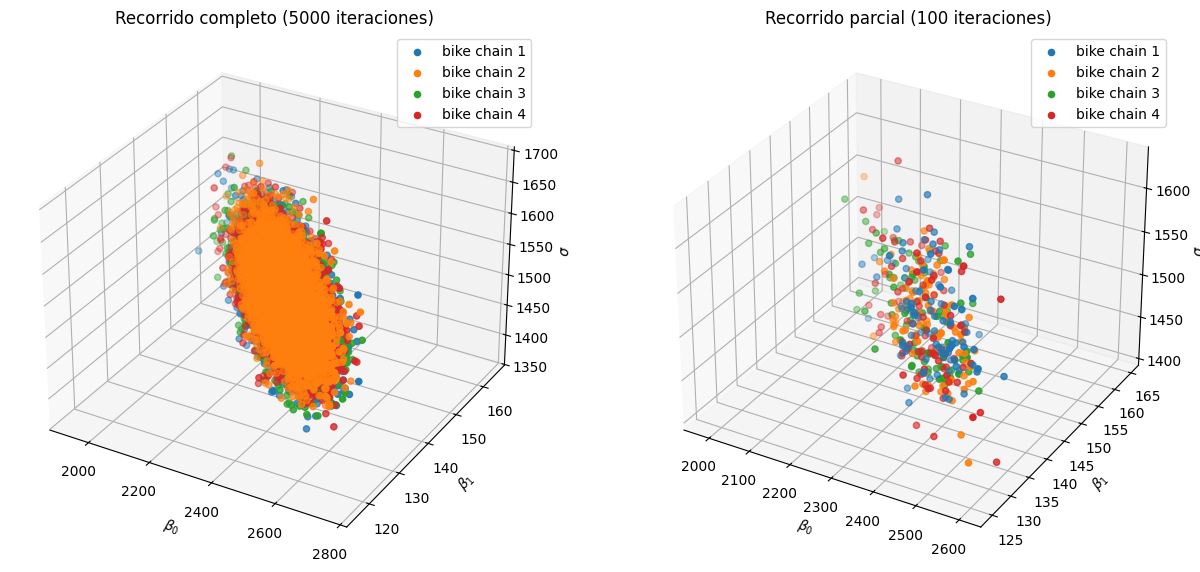



#### Vemos que las cadenas no arrancan desde una posicion inical y van convergiendo sino que comienzan cerca de la zona de convergencia



In [19]:
fig = plt.figure(figsize=(15,15))

ax0 = fig.add_subplot(121, projection='3d')

ax0.scatter(idata.posterior["beta_0"][0], idata.posterior["beta_1"][0], idata.posterior["sigma"][0], label='bike chain 1')
ax0.scatter(idata.posterior["beta_0"][1], idata.posterior["beta_1"][1], idata.posterior["sigma"][1], label='bike chain 2')
ax0.scatter(idata.posterior["beta_0"][2], idata.posterior["beta_1"][2], idata.posterior["sigma"][2], label='bike chain 3')
ax0.scatter(idata.posterior["beta_0"][3], idata.posterior["beta_1"][3], idata.posterior["sigma"][3], label='bike chain 4')

ax0.set_xlabel(r'$\beta_{0}$')
ax0.set_ylabel(r'$\beta_{1}$')
ax0.set_zlabel(r'$\sigma$')
ax0.set_title('Recorrido completo (5000 iteraciones)')

ax0.legend()

ax1 = fig.add_subplot(122, projection='3d')

pymc_convergence_iterations = 100

ax1.scatter(idata.posterior["beta_0"][0][:pymc_convergence_iterations], idata.posterior["beta_1"][0][:pymc_convergence_iterations], idata.posterior["sigma"][0][:pymc_convergence_iterations], label='bike chain 1')
ax1.scatter(idata.posterior["beta_0"][1][:pymc_convergence_iterations], idata.posterior["beta_1"][1][:pymc_convergence_iterations], idata.posterior["sigma"][1][:pymc_convergence_iterations], label='bike chain 2')
ax1.scatter(idata.posterior["beta_0"][2][:pymc_convergence_iterations], idata.posterior["beta_1"][2][:pymc_convergence_iterations], idata.posterior["sigma"][2][:pymc_convergence_iterations], label='bike chain 3')
ax1.scatter(idata.posterior["beta_0"][3][:pymc_convergence_iterations], idata.posterior["beta_1"][3][:pymc_convergence_iterations], idata.posterior["sigma"][3][:pymc_convergence_iterations], label='bike chain 4')

ax1.set_xlabel(r'$\beta_{0}$')
ax1.set_ylabel(r'$\beta_{1}$')
ax1.set_zlabel(r'$\sigma$')
ax1.set_title(f'Recorrido parcial ({pymc_convergence_iterations} iteraciones)')

ax1.legend()

plt.show()


Markdown(fr"""

#### Vemos que las cadenas no arrancan desde una posicion inical y van convergiendo sino que comienzan cerca de la zona de convergencia

""")

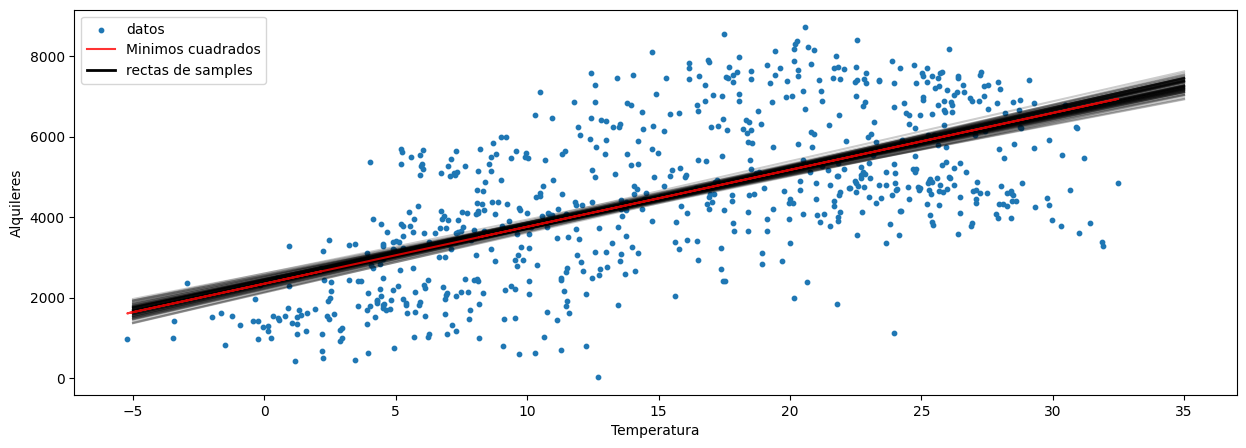



#### Vemos que las rectas de la posterior tienden a centrarse a la recta de minimos cuadrados y que algunas de las rectas factibles tienen una pendiente mas baja y un intercepto mas alta o una pendiente mas alta e intercepcion mas alta



In [20]:
plt.figure(figsize=(15, 5))

plt.scatter(df_bikes.temp, df_bikes.cnt, s=10, label = 'datos')

x = np.linspace(-5, 35, 100)

for i in range(100):
    plt.plot(x, idata.posterior["beta_0"][0][i].item() + idata.posterior["beta_1"][0][i].item() * x, color = 'black', alpha=0.2)

regression_line = np.polyval(np.polyfit(df_bikes.temp, df_bikes.cnt, 1), df_bikes.temp)
plt.plot(df_bikes.temp, regression_line, color='red', alpha= 0.8, label = 'Minimos cuadrados')


handles, labels = plt.gca().get_legend_handles_labels()
legend_item = Line2D([0], [0], label='rectas de samples', color='black', lw=2)
handles.append(legend_item)
plt.legend(handles=handles, labels=labels + ['rectas de samples'])

plt.xlabel('Temperatura')
plt.ylabel('Alquileres')
plt.show()



Markdown(fr"""

#### Vemos que las rectas de la posterior tienden a centrarse a la recta de minimos cuadrados y que algunas de las rectas factibles tienen una pendiente mas baja y un intercepto mas alta o una pendiente mas alta e intercepcion mas alta

""")

## B) Coinciden los posteriors marginales (los de cada parametro por separado) con los calculados en el ejercicio 2?

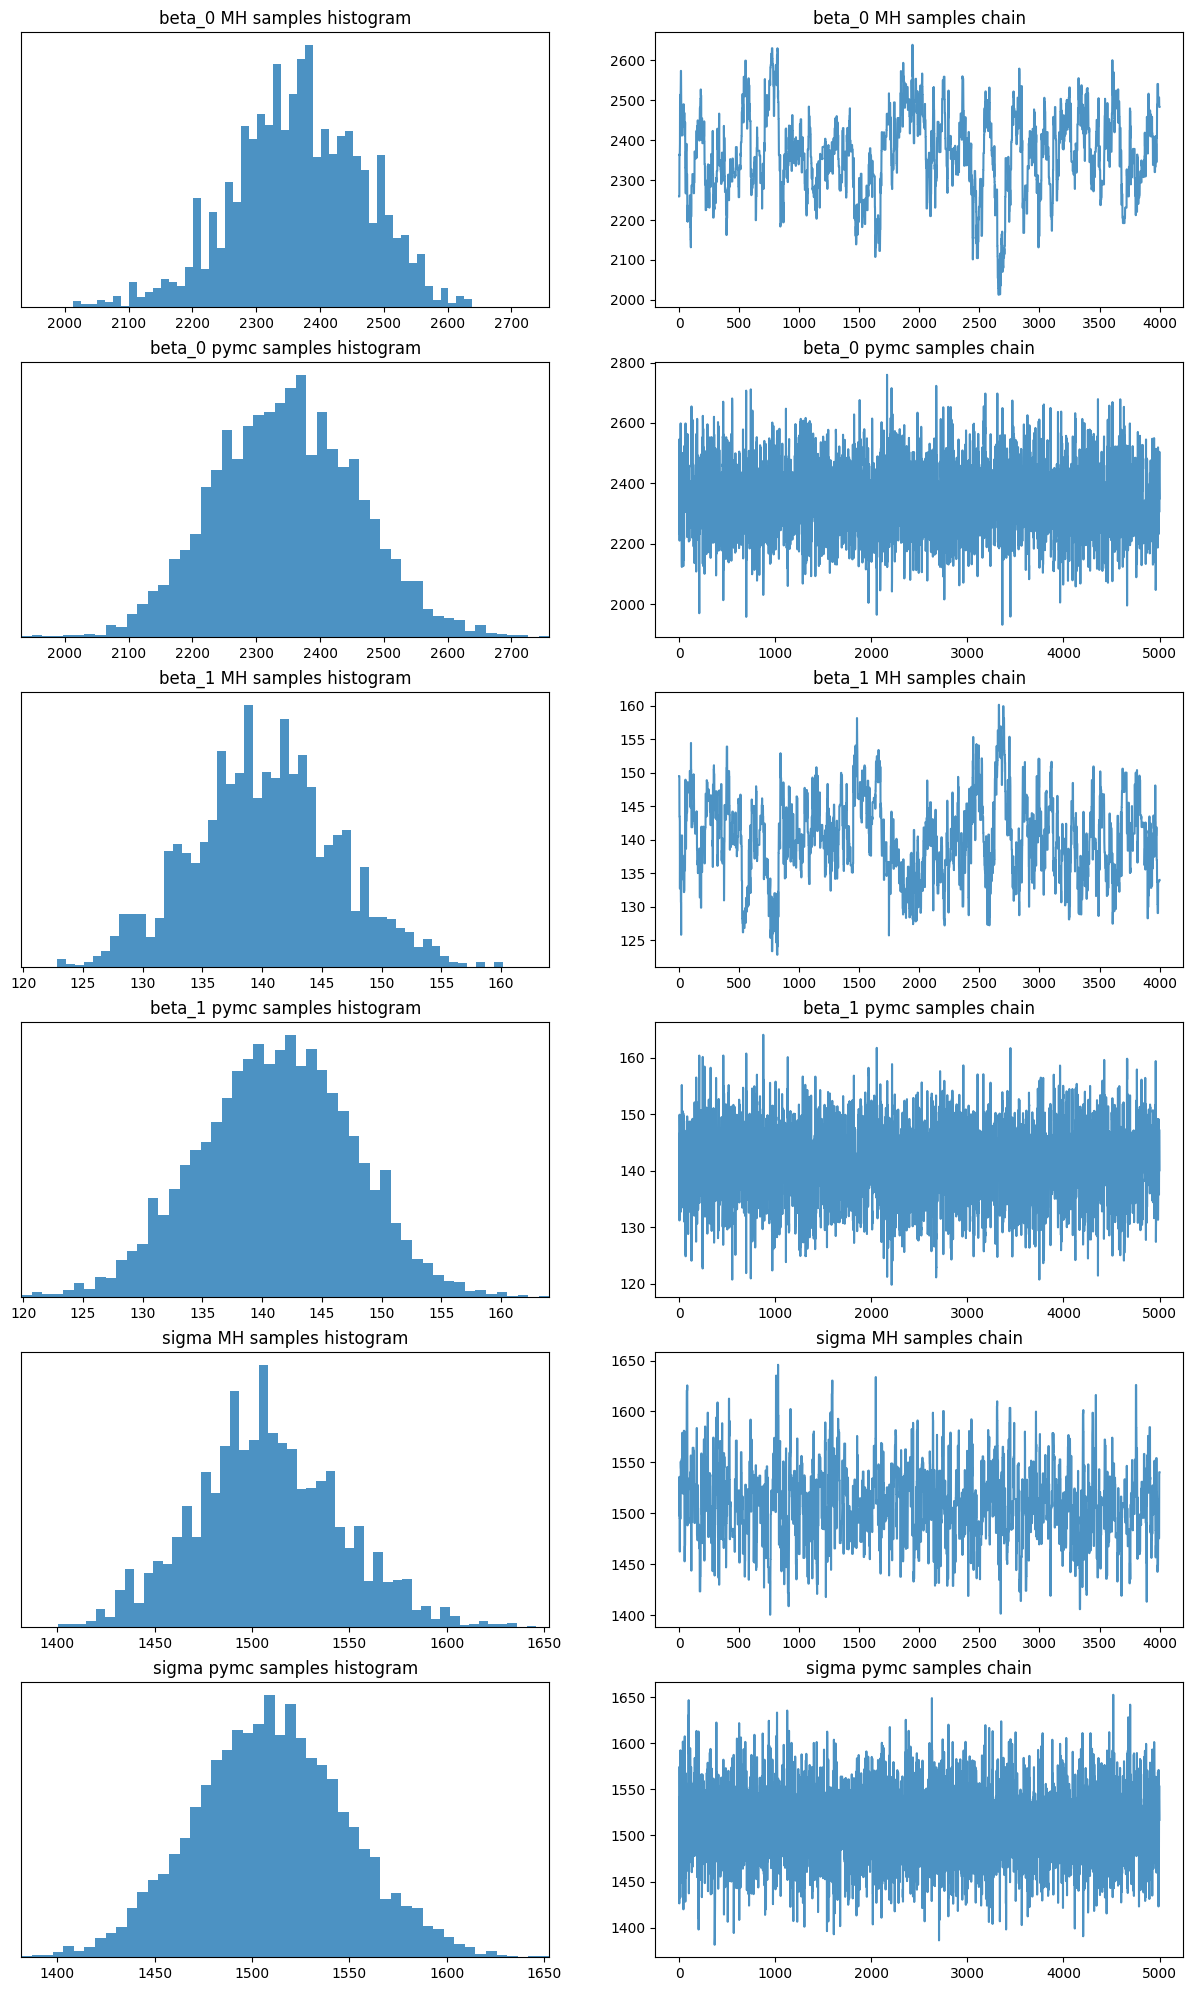



#### Vemos que las distribuciones entre metropilis hasting y pymc se parecen mucho, tanto el histograma como la cadenas de samples, lo que podemos notar es que las cadenas de MH parecen tener un mayor indice de correlacion que las de pymc y vemos que se pueden llegar a afectar las predicciones ya que los histogramas no son tan \'suaves\'



In [21]:
_, ax = plt.subplots(6, 2, figsize=(15, 25))

for index, param in enumerate(['beta_0', 'beta_1', 'sigma']):
    
    index = index * 2

    min_value = min(np.min(bike_chain_1[mc_convergence_iterations:][:, index//2]), np.min(idata.posterior[param][0]))
    max_value = max(np.max(bike_chain_1[mc_convergence_iterations:][:, index//2]), np.max(idata.posterior[param][0]))
    ax[index, 0].set_xlim(min_value, max_value)
    ax[index + 1, 0].set_xlim(min_value, max_value)

    ax[index, 0].set_title(f"{param} MH samples histogram")
    ax[index, 0].set_yticks([])
    ax[index, 0].hist(bike_chain_1[mc_convergence_iterations:][:, index//2], alpha=0.8, density=True, bins=50)

    ax[index + 1, 0].set_title(f"{param} pymc samples histogram")
    ax[index + 1, 0].set_yticks([])
    ax[index + 1, 0].hist(idata.posterior[param][0], alpha=0.8, density=True, bins=50)

    ax[index, 1].set_title(f"{param} MH samples chain")
    ax[index, 1].plot(np.arange(len(bike_chain_1[mc_convergence_iterations:][:, index//2])), bike_chain_1[mc_convergence_iterations:][:, index//2], alpha=0.8, linestyle='-')

    ax[index + 1, 1].set_title(f"{param} pymc samples chain")
    ax[index + 1, 1].plot(np.arange(len(idata.posterior[param][0])), idata.posterior[param][0], alpha=0.8, linestyle='-')

plt.show()

Markdown(fr"""

#### Vemos que las distribuciones entre metropilis hasting y pymc se parecen mucho, tanto el histograma como la cadenas de samples, lo que podemos notar es que las cadenas de MH parecen tener un mayor indice de correlacion que las de pymc y vemos que se pueden llegar a afectar las predicciones ya que los histogramas no son tan \'suaves\'

""")

## C) Compute la respuesta al item G) del Ejercicio 2. Coinciden estas respuestas?

### Cual es la probabilidad de que un dia de 20 grados tenga mas de 6000 alquileres de bicicletas?

In [22]:
# obtenemos 5000 samples de la posterior
bikes_5000_posteriors = bike_final_chain[np.random.choice(bike_final_chain.shape[0], 5000, replace=False)]

MH_days_with_more_than_6000_rides = 0
pymc_days_with_more_than_6000_rides = 0

for k in range(len(bikes_5000_posteriors)):
    posterior_sample = bikes_5000_posteriors[k]
    temperature_predicted = np.random.normal(posterior_sample[0] + posterior_sample[1] * 20, posterior_sample[2], 1)
    if temperature_predicted > 6000:
        MH_days_with_more_than_6000_rides += 1

    temperature_predicted = np.random.normal(idata.posterior["beta_0"][0][k].item() + idata.posterior["beta_1"][0][k].item() * 20, idata.posterior["sigma"][0][k].item(), 1)
    if temperature_predicted > 6000:
        pymc_days_with_more_than_6000_rides += 1


Markdown(fr"""

### MH: La probabilidad de que el tiempo de alquiler de bicicletas sea mayor a 6000 es de {MH_days_with_more_than_6000_rides/len(bikes_5000_posteriors)}.
### pymc: La probabilidad de que el tiempo de alquiler de bicicletas sea mayor a 6000 es de {pymc_days_with_more_than_6000_rides/len(bikes_5000_posteriors)}.

#### Vemos que hay una diferencia insignificante entre los valores predichos por MH y pymc, podriamos usar cualquiera de los 2 para hacer predicciones aunque como vimos en el punto anterior pymc parece hacer un mejor trabajo en generar cadenas independientes

""")




### MH: La probabilidad de que el tiempo de alquiler de bicicletas sea mayor a 6000 es de 0.2984.
### pymc: La probabilidad de que el tiempo de alquiler de bicicletas sea mayor a 6000 es de 0.2948.

#### Vemos que hay una diferencia insignificante entre los valores predichos por MH y pymc, podriamos usar cualquiera de los 2 para hacer predicciones aunque como vimos en el punto anterior pymc parece hacer un mejor trabajo en generar cadenas independientes



### Cuantos alquileres de bicis voy a tener en un dia de 25 grados?

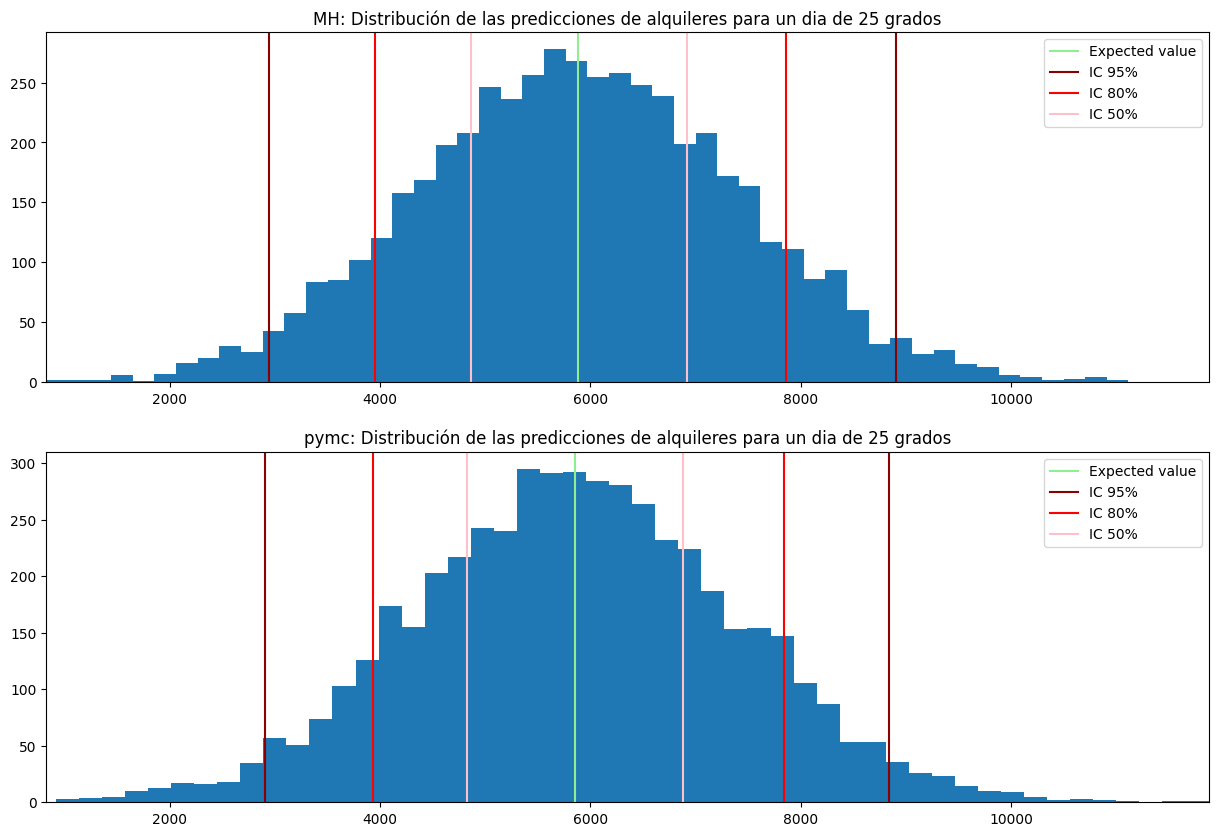



#### Vemos que hay una diferencia insignificante entre los valores predichos por MH y pymc, podriamos usar cualquiera de los 2 para hacer predicciones aunque como vimos en el punto anterior pymc parece hacer un mejor trabajo en generar cadenas independientes



In [23]:
MH_temperatures_predicted = np.array([])
pymc_temperatures_predicted = np.array([])


for k in range(len(bikes_5000_posteriors)):
    posterior_sample = bikes_5000_posteriors[k]
    temperature_predicted = np.random.normal(posterior_sample[0] + posterior_sample[1] * 25, posterior_sample[2], 1)
    MH_temperatures_predicted = np.append(MH_temperatures_predicted, temperature_predicted)

    temperature_predicted = np.random.normal(idata.posterior["beta_0"][0][k].item() + idata.posterior["beta_1"][0][k].item() * 25, idata.posterior["sigma"][0][k].item(), 1)
    pymc_temperatures_predicted = np.append(pymc_temperatures_predicted, temperature_predicted)


min_value = min(np.min(MH_temperatures_predicted), np.min(pymc_temperatures_predicted))
max_value = max(np.max(MH_temperatures_predicted), np.max(pymc_temperatures_predicted))


_, ax = plt.subplots(2, 1, figsize=(15, 10))

for i, (temperatures_predicted, name) in enumerate([(MH_temperatures_predicted, "MH"), (pymc_temperatures_predicted, "pymc")]):
    ax[i].set_title(f'{name}: Distribución de las predicciones de alquileres para un dia de 25 grados')
    ax[i].set_xlim(min_value, max_value)

    ax[i].hist(temperatures_predicted, bins=50)

    percentil_50 = np.percentile(temperatures_predicted, 50)
    percentil_2_5 = np.percentile(temperatures_predicted, 2.5)
    percentil_10 = np.percentile(temperatures_predicted, 10)
    percentil_25 = np.percentile(temperatures_predicted, 25)
    percentil_75 = np.percentile(temperatures_predicted, 75)
    percentil_90 = np.percentile(temperatures_predicted, 90)
    percentil_97_5 = np.percentile(temperatures_predicted, 97.5)

    ax[i].axvline(percentil_50, color = 'lightgreen', label = 'Expected value')

    ax[i].axvline(percentil_2_5, color = 'darkred')
    ax[i].axvline(percentil_97_5, color = 'darkred', label = 'IC 95%')

    ax[i].axvline(percentil_10, color = 'red')
    ax[i].axvline(percentil_90, color = 'red', label = 'IC 80%')

    ax[i].axvline(percentil_25, color = 'pink')
    ax[i].axvline(percentil_75, color = 'pink', label = 'IC 50%')

    ax[i].legend()

plt.show()


Markdown(fr"""

#### Vemos que hay una diferencia insignificante entre los valores predichos por MH y pymc, podriamos usar cualquiera de los 2 para hacer predicciones aunque como vimos en el punto anterior pymc parece hacer un mejor trabajo en generar cadenas independientes

""")

In [66]:
MH_temperatures_predicted = np.array([])
pymc_temperatures_predicted = np.array([])

for k in range(len(df_bikes.cnt.values)):
    posterior_sample = bikes_5000_posteriors[k]
    temperature_predicted = np.random.normal(posterior_sample[0] + posterior_sample[1] * df_bikes.temp[k], posterior_sample[2], 1)
    MH_temperatures_predicted = np.append(MH_temperatures_predicted, temperature_predicted)

    temperature_predicted = np.random.normal(idata.posterior["beta_0"][0][k].item() + idata.posterior["beta_1"][0][k].item() * df_bikes.temp[k], idata.posterior["sigma"][0][k].item(), 1)
    pymc_temperatures_predicted = np.append(pymc_temperatures_predicted, temperature_predicted)

### Comparacion de Posterior predictive vs datos

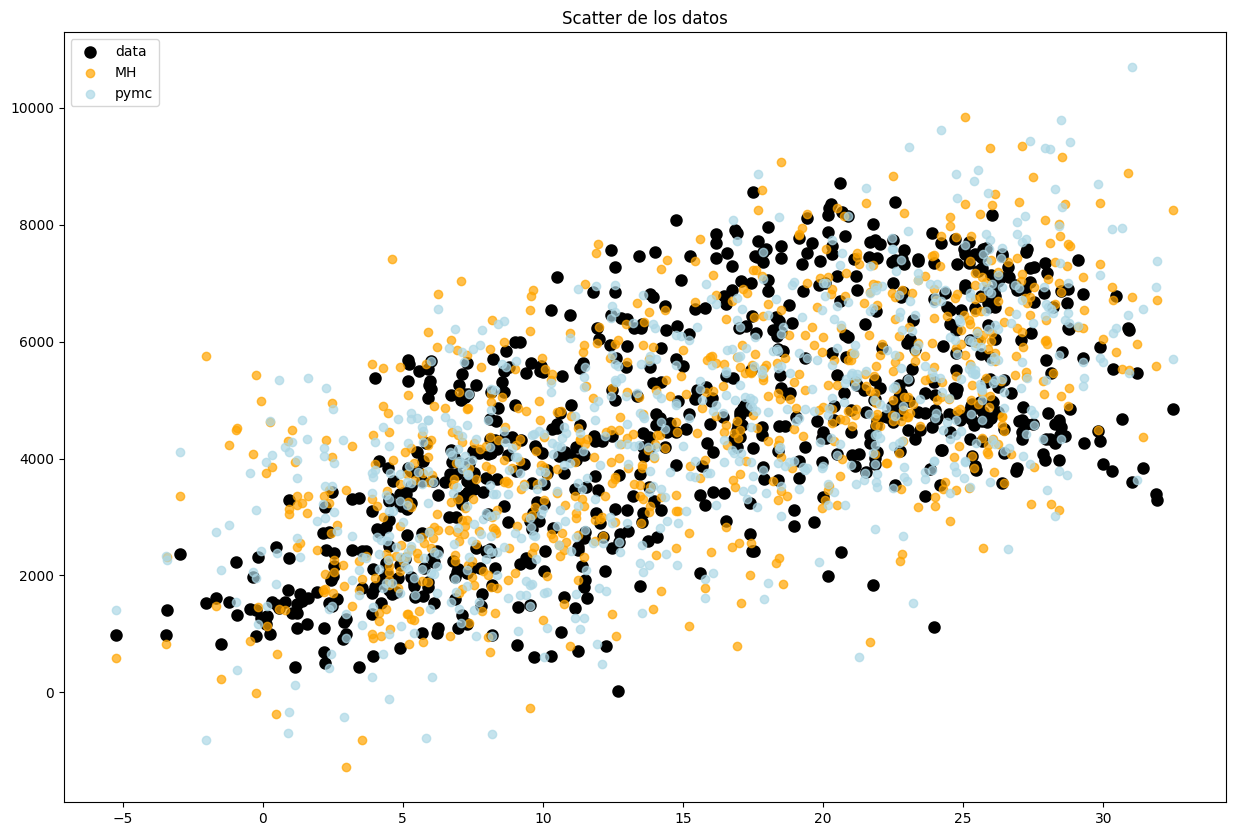



#### Vemos que los datos generados con el modelo se parecen a los reales pero hay ciertas areas en las que no. ya que para temperaturas menores a 5 grados y mayores a 25 grados, los datos generados tienen valores mas altos que los de nuestros datos y tambien vemos que en todo el rango de temperatuas generamos varios datos con cantidad de alquileres menor a los de los datos



In [73]:
plt.figure(figsize=(15, 10))

plt.title('Scatter de los datos')

plt.scatter(df_bikes.temp.values, df_bikes.cnt.values, color = 'black', label = 'data', linewidth=3)
plt.scatter(df_bikes.temp.values, MH_temperatures_predicted, color = 'orange', label = 'MH', alpha=0.7)
plt.scatter(df_bikes.temp.values, pymc_temperatures_predicted, color = 'lightblue', label = 'pymc', alpha=0.7)
plt.legend()
plt.show()

Markdown(fr"""

#### Vemos que los datos generados con el modelo se parecen a los reales pero hay ciertas areas en las que no. ya que para temperaturas menores a 5 grados y mayores a 25 grados, los datos generados tienen valores mas altos que los de nuestros datos y tambien vemos que en todo el rango de temperatuas generamos varios datos con cantidad de alquileres menor a los de los datos

""")

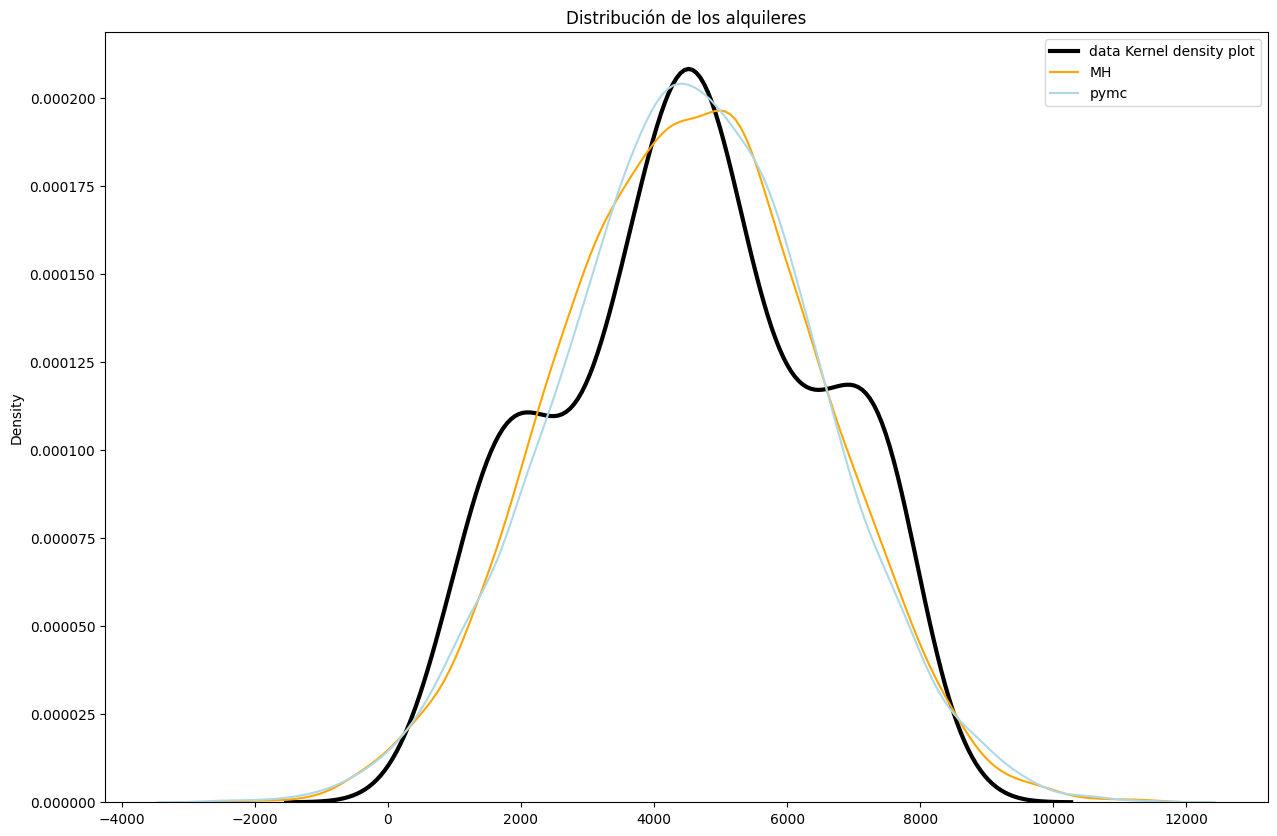



#### Ploteamos la distribucion de los alquileres de los datos vs la de los alquileres simulados para cada valor de temperatura en nuestros datos y vemos como si bien el modelo genera datos que se parecen en tendencia y spread a los originales vemos que no captura la trimodalidad que existe en los datos correctamente y nos dice que podriamos hacer un modelo mejor



In [64]:
bins = 20

plt.figure(figsize=(15, 10))

plt.title('Distribución de los alquileres')

sns.kdeplot(df_bikes.cnt.values, color = 'black', label = 'data Kernel density plot', linewidth=3)
sns.kdeplot(MH_temperatures_predicted, color = 'orange', label = 'MH')
sns.kdeplot(pymc_temperatures_predicted, color = 'lightblue', label = 'pymc')
plt.legend()
plt.show()

Markdown(fr"""

#### Ploteamos la distribucion de los alquileres de los datos vs la de los alquileres simulados para cada valor de temperatura en nuestros datos y vemos como si bien el modelo genera datos que se parecen en tendencia y spread a los originales vemos que no captura la trimodalidad que existe en los datos correctamente y nos dice que podriamos hacer un modelo mejor

""")

# Bonus Track

### Vamos a extender el modelo a uno con mas componentes lineales con la esperanza de generar un modelo que capture mejor el comportamiento de los datos y vamos a compararlo con el modelo anterior

Para esto vamos a introducir mas variables predictoras como la humedad, viento, si el dia de la semana es fin de semana o no

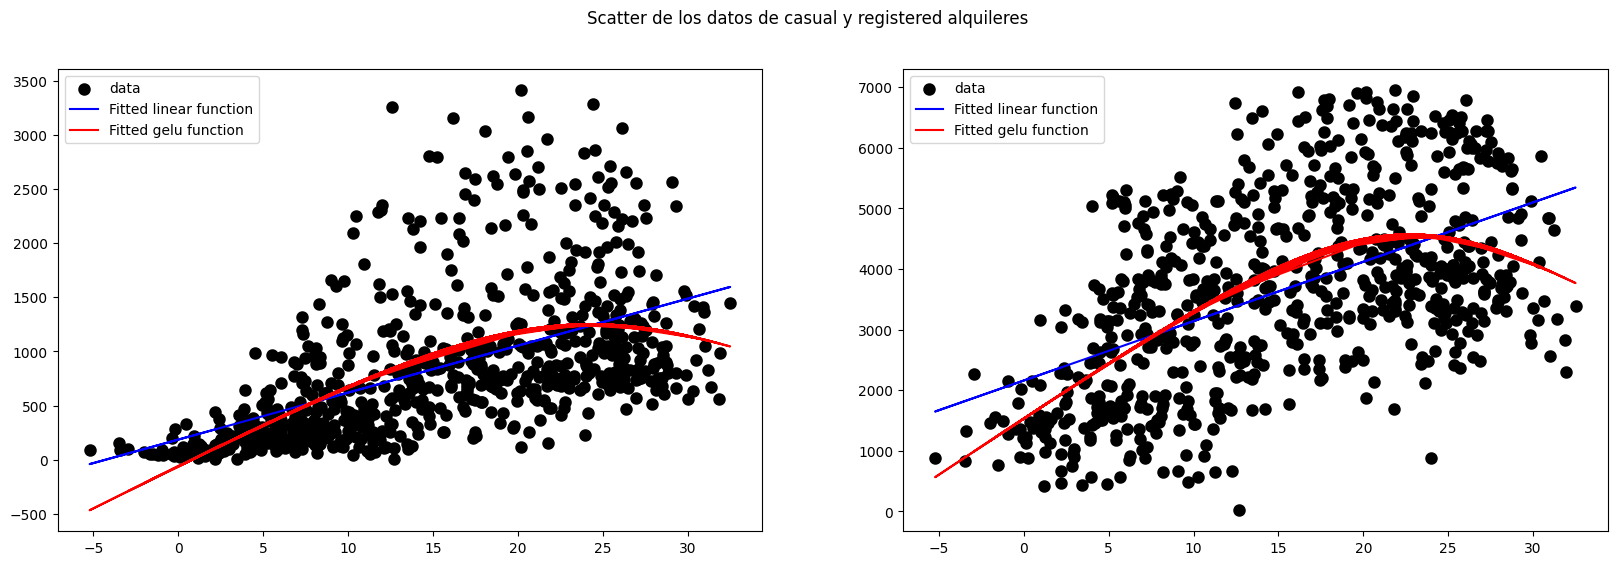

In [186]:
def linear(x, c, d):
    return c + d * x

def gelu_func(x, a, b, c, d, e):
    return c + d * (x-e) * (1 + np.tanh(((x-e) + a) / b))



_, ax = plt.subplots(1, 2, figsize=(20, 6))

plt.suptitle('Scatter de los datos de casual y registered alquileres')

for k, y in enumerate([df_bikes.casual.values, df_bikes.registered.values]):

    popt_linear, pcov = curve_fit(linear, df_bikes.temp.values, y)
    bounds = ([-100, -100, popt_linear[0]*9/10, popt_linear[1]*9/10, -10000], [100, 0, popt_linear[0]*11/10, popt_linear[1]*11/10, 10000])
    popt_gelu, pcov = curve_fit(gelu_func, df_bikes.temp.values, y, bounds=bounds)

    ax[k].scatter(df_bikes.temp.values, y, color = 'black', label = 'data', linewidth=3)
    ax[k].plot(df_bikes.temp.values, linear(df_bikes.temp.values, *popt_linear), 'b-', label='Fitted linear function')
    ax[k].plot(df_bikes.temp.values, gelu_func(df_bikes.temp.values, *popt_gelu), 'r-', label='Fitted gelu function')

    ax[k].legend()

plt.show()


In [176]:
popt_gelu

array([ -26.12441162,  -12.33461689, 2110.47816247,  127.16253186,
          2.37015856])

In [123]:
Markdown(fr"""
         
Priors de nuevo modelo:

$$
\text{{data:}} \quad log(Y_{{i}})|\beta_{{0}}, \beta_{{1}}, \beta_{{2}}, \beta_{{3}}, \beta_{{4}} ,\sigma \sim \mathcal{{N}}(\mu_{{i}}, \sigma^{{2}}) \quad  \text{{with}} \quad  \mu(x_{{i}}) = \beta_{{0}} + \beta_{{1}} \cdot X_{{1i}} + \beta_{{12}} \cdot X_{{1i}} \cdot X_{{2i}} + \beta_{{2}} \cdot X_{{2i}} + \beta_{{3}} \cdot X_{{3i}} + \beta_{{4}} \cdot X_{{4i}}
$$

$$
\text{{with}} \quad X_{{1i}} = Temperature,\quad X_{{2i}} = Humidity,\quad X_{{3i}} = Wind,\quad X_{{4i}} = 1 \quad \text{{if its a workday else }}\quad 0
$$

$$
\text{{priors:}} \quad \beta_{{0}} \sim \mathcal{{N}}({mean_rides}, 3000^{{2}})
$$
$$
\quad \quad \quad \quad \beta_{{1}} \sim \mathcal{{N}}(200, 200^{{2}})
$$
$$
\quad \quad \quad \quad \beta_{{12}} \sim \mathcal{{N}}(0, 200^{{2}})
$$
$$
\quad \quad \quad \quad \beta_{{2}} \sim \mathcal{{N}}(0, 200^{{2}})
$$
$$
\quad \quad \quad \quad \beta_{{3}} \sim \mathcal{{N}}(0, 200^{{2}})
$$
$$
\quad \quad \quad \quad \beta_{{4}} \sim \mathcal{{N}}(3000, 3000^{{2}})
$$
$$
\quad \quad \quad \sigma \sim Exp({round(1/1000, 6)})
$$

""")


         
Priors de nuevo modelo:

$$
\text{data:} \quad log(Y_{i})|\beta_{0}, \beta_{1}, \beta_{2}, \beta_{3}, \beta_{4} ,\sigma \sim \mathcal{N}(\mu_{i}, \sigma^{2}) \quad  \text{with} \quad  \mu(x_{i}) = \beta_{0} + \beta_{1} \cdot X_{1i} + \beta_{12} \cdot X_{1i} \cdot X_{2i} + \beta_{2} \cdot X_{2i} + \beta_{3} \cdot X_{3i} + \beta_{4} \cdot X_{4i}
$$

$$
\text{with} \quad X_{1i} = Temperature,\quad X_{2i} = Humidity,\quad X_{3i} = Wind,\quad X_{4i} = 1 \quad \text{if its a workday else }\quad 0
$$

$$
\text{priors:} \quad \beta_{0} \sim \mathcal{N}(5177.382, 3000^{2})
$$
$$
\quad \quad \quad \quad \beta_{1} \sim \mathcal{N}(200, 200^{2})
$$
$$
\quad \quad \quad \quad \beta_{12} \sim \mathcal{N}(0, 200^{2})
$$
$$
\quad \quad \quad \quad \beta_{2} \sim \mathcal{N}(0, 200^{2})
$$
$$
\quad \quad \quad \quad \beta_{3} \sim \mathcal{N}(0, 200^{2})
$$
$$
\quad \quad \quad \quad \beta_{4} \sim \mathcal{N}(3000, 3000^{2})
$$
$$
\quad \quad \quad \sigma \sim Exp(0.001)
$$



In [189]:
popt_gelu

array([ -25.58655983,  -12.73373768, 1943.50755517,   92.86067825,
          2.24270293])

In [192]:
with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    beta_0 = pm.Normal("beta_0", beta_0_mean, sigma=beta_0_std)
    beta_1 = pm.Normal("beta_1", beta_1_mean, sigma=beta_1_std)
    beta_12 = pm.Normal("beta_12", 0, sigma=200)
    beta_2 = pm.Normal("beta_2", 0, sigma=200)
    beta_3 = pm.Normal("beta_3", 0, sigma=200)
    beta_4 = pm.Normal("beta_4", 3000, sigma=3000)
    sigma = pm.Exponential("sigma", scale=sigma_scale)

    a = pm.Normal("a", popt_gelu[0], sigma=np.abs(popt_gelu[0]/5))
    b = pm.Normal("b", popt_gelu[1], sigma=np.abs(popt_gelu[1]/5))
    c = pm.Normal("c", popt_gelu[2], sigma=popt_gelu[2])
    d = pm.Normal("d", popt_gelu[3], sigma=popt_gelu[3])
    e = pm.Normal("e", popt_gelu[4], sigma=popt_gelu[4])

    # Define likelihood
    likelihood = pm.Normal("y", 
        mu = gelu_func(
            beta_0 + beta_1 * df_bikes.temp.values + beta_12 * df_bikes.temp.values * df_bikes.hum.values + beta_2 * df_bikes.hum.values + beta_3 * df_bikes.windspeed.values + beta_4 * df_bikes.workingday.values,
                a,b,c,d,e
            ),
        sigma=sigma,
        observed=df_bikes.registered.values
    )

    # Inference!
    # draw 5000 posterior samples using NUTS sampling
    idata_registered = pm.sample(2000, chains = 1)

with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    beta_0 = pm.Normal("beta_0", beta_0_mean, sigma=beta_0_std)
    beta_1 = pm.Normal("beta_1", beta_1_mean, sigma=beta_1_std)
    beta_12 = pm.Normal("beta_12", 0, sigma=200)
    beta_2 = pm.Normal("beta_2", 0, sigma=200)
    beta_3 = pm.Normal("beta_3", 0, sigma=200)
    beta_4 = pm.Normal("beta_4", 3000, sigma=3000)
    sigma = pm.Exponential("sigma", scale=sigma_scale)

    # Define likelihood
    likelihood = pm.Normal("y", 
        mu = beta_0 + beta_1 * df_bikes.temp.values + beta_12 * df_bikes.temp.values * df_bikes.hum.values + beta_2 * df_bikes.hum.values + beta_3 * df_bikes.windspeed.values + beta_4 * df_bikes.workingday.values,
        sigma=sigma,
        observed=df_bikes.casual.values
    )

    # Inference!
    # draw 5000 posterior samples using NUTS sampling
    idata_casual = pm.sample(2000, chains = 1)

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (1 chains in 1 job)
NUTS: [beta_0, beta_1, beta_12, beta_2, beta_3, beta_4, sigma, a, b, c, d, e]
INFO:pymc.sampling.mcmc:NUTS: [beta_0, beta_1, beta_12, beta_2, beta_3, beta_4, sigma, a, b, c, d, e]


/home/matias/Database/files/Vault/files/Repos/UBA/EstimacionBayesiana/.venv/lib/python3.12/site-packages/rich/live.
py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO:pymc.sampling.mcmc:Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
There were 1068 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 1068 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc.stats.convergence:Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (1 chains in 1 job)
NUTS: [beta_0, beta_1, beta_12, beta_2, beta_3, beta_4, sigma]
INFO:p

/home/matias/Database/files/Vault/files/Repos/UBA/EstimacionBayesiana/.venv/lib/python3.12/site-packages/rich/live.
py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 29 seconds.
INFO:pymc.sampling.mcmc:Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 29 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc.stats.convergence:Only one chain was sampled, this makes it impossible to run some convergence checks


In [198]:
temperatures_predicted = np.zeros((len(df_bikes.cnt.values), 2))

for k in range(len(df_bikes.cnt.values)):

    
    temperature_predicted_registered = np.random.normal(
        gelu_func(
            idata_registered.posterior["beta_0"][0][k].item() + 
            idata_registered.posterior["beta_1"][0][k].item() * df_bikes.temp[k] +
            idata_registered.posterior["beta_12"][0][k].item() * df_bikes.temp[k] * df_bikes.hum[k] +
            idata_registered.posterior["beta_2"][0][k].item() * df_bikes.hum[k] +
            idata_registered.posterior["beta_3"][0][k].item() * df_bikes.windspeed[k] +
            idata_registered.posterior["beta_4"][0][k].item() * df_bikes.workingday[k],
                idata_registered.posterior["a"][0][k].item(),
                idata_registered.posterior["b"][0][k].item(),
                idata_registered.posterior["c"][0][k].item(),
                idata_registered.posterior["d"][0][k].item(),
                idata_registered.posterior["e"][0][k].item(),
        ),
        idata_registered.posterior["sigma"][0][k].item(),
        1
    )
    
    temperature_predicted_casual = np.random.normal(
        idata_casual.posterior["beta_0"][0][k].item() + 
        idata_casual.posterior["beta_1"][0][k].item() * df_bikes.temp[k] +
        idata_casual.posterior["beta_12"][0][k].item() * df_bikes.temp[k] * df_bikes.hum[k] +
        idata_casual.posterior["beta_2"][0][k].item() * df_bikes.hum[k] +
        idata_casual.posterior["beta_3"][0][k].item() * df_bikes.windspeed[k] +
        idata_casual.posterior["beta_4"][0][k].item() * df_bikes.workingday[k],
        idata_casual.posterior["sigma"][0][k].item(), 1)
    
    temperatures_predicted[k, 0] = temperature_predicted_registered
    temperatures_predicted[k, 1] = temperature_predicted_casual

/tmp/ipykernel_417200/3190247933.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temperatures_predicted[k, 0] = temperature_predicted_registered
/tmp/ipykernel_417200/3190247933.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temperatures_predicted[k, 1] = temperature_predicted_casual


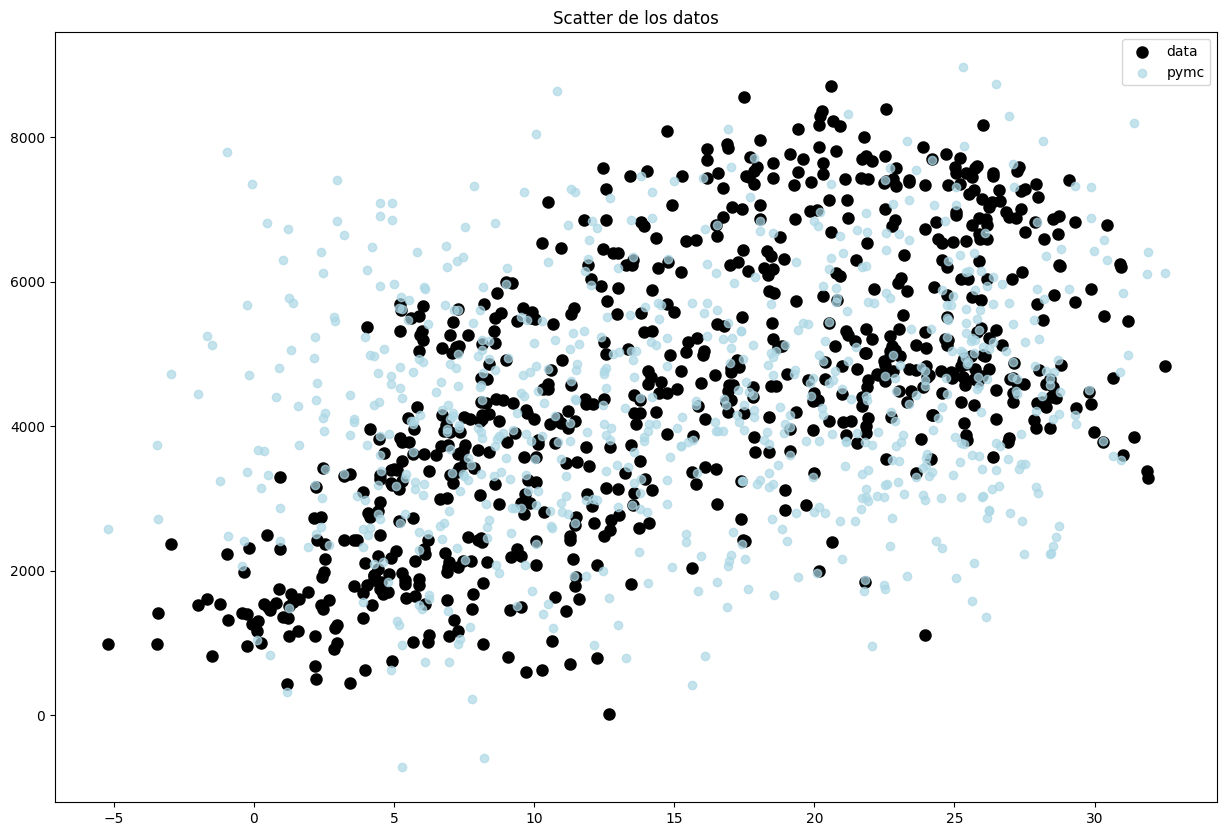



#### Vemos que los datos generados con el modelo se parecen a los reales pero hay ciertas areas en las que no. ya que para temperaturas menores a 5 grados y mayores a 25 grados, los datos generados tienen valores mas altos que los de nuestros datos y tambien vemos que en todo el rango de temperatuas generamos varios datos con cantidad de alquileres menor a los de los datos



In [199]:
plt.figure(figsize=(15, 10))

plt.title('Scatter de los datos')

plt.scatter(df_bikes.temp.values, df_bikes.cnt.values, color = 'black', label = 'data', linewidth=3)
plt.scatter(df_bikes.temp.values, temperatures_predicted[:, 0] + temperatures_predicted[:, 1], color = 'lightblue', label = 'pymc', alpha=0.7)
plt.legend()
plt.show()

Markdown(fr"""

#### Vemos que los datos generados con el modelo se parecen a los reales pero hay ciertas areas en las que no. ya que para temperaturas menores a 5 grados y mayores a 25 grados, los datos generados tienen valores mas altos que los de nuestros datos y tambien vemos que en todo el rango de temperatuas generamos varios datos con cantidad de alquileres menor a los de los datos

""")

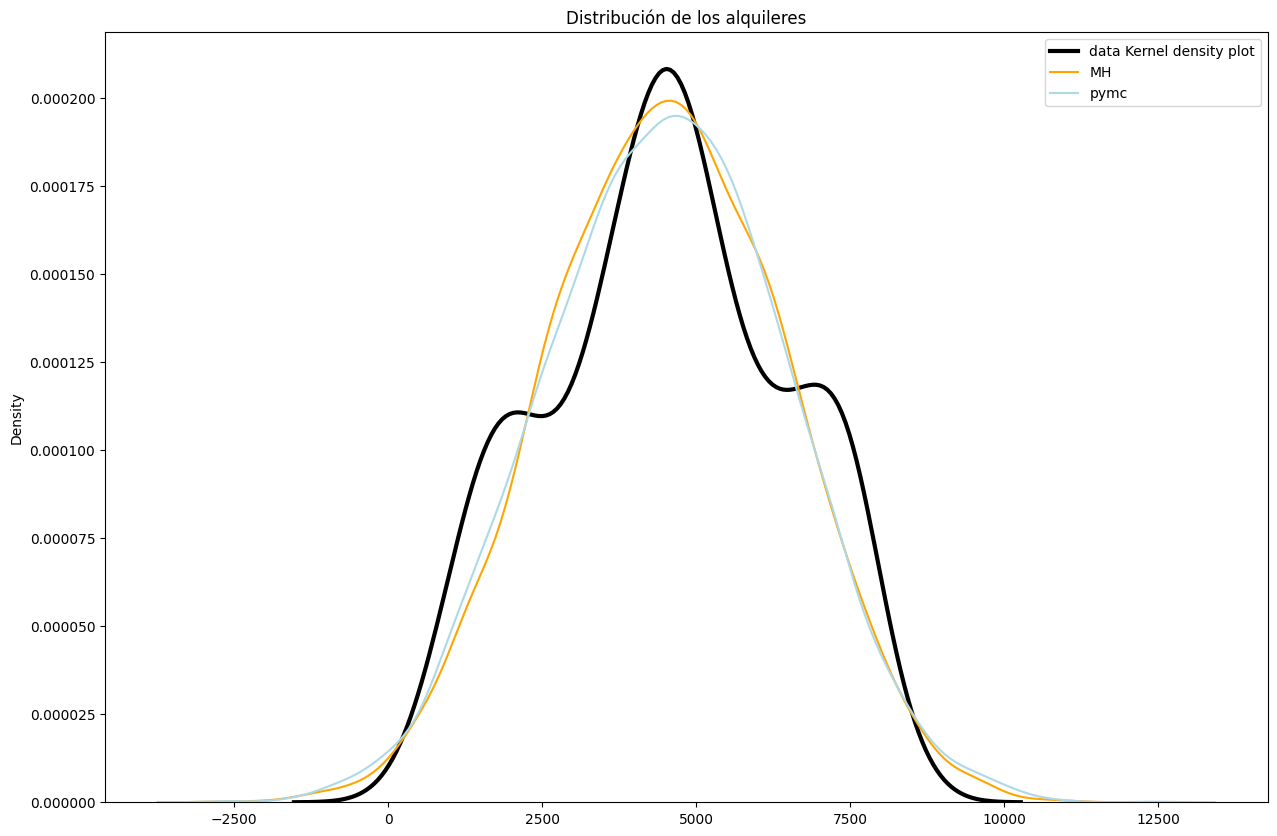

In [ ]:
MH_temperatures_predicted = np.array([])
pymc_temperatures_predicted = np.array([])

for k in range(len(df_bikes.cnt.values)):
    posterior_sample = bikes_5000_posteriors[k]
    temperature_predicted = np.random.normal(posterior_sample[0] + posterior_sample[1] * df_bikes.temp[k], posterior_sample[2], 10)
    MH_temperatures_predicted = np.append(MH_temperatures_predicted, temperature_predicted)

    temperature_predicted = np.random.normal(idata.posterior["beta_0"][0][k].item() + idata.posterior["beta_1"][0][k].item() * df_bikes.temp[k], idata.posterior["sigma"][0][k].item(), 10)
    pymc_temperatures_predicted = np.append(pymc_temperatures_predicted, temperature_predicted)


bins = 20

plt.figure(figsize=(15, 10))

plt.title('Distribución de los alquileres')

sns.kdeplot(df_bikes.cnt.values, color = 'black', label = 'data Kernel density plot', linewidth=3)
sns.kdeplot(MH_temperatures_predicted, color = 'orange', label = 'MH')
sns.kdeplot(pymc_temperatures_predicted, color = 'lightblue', label = 'pymc')
plt.legend()
plt.show()

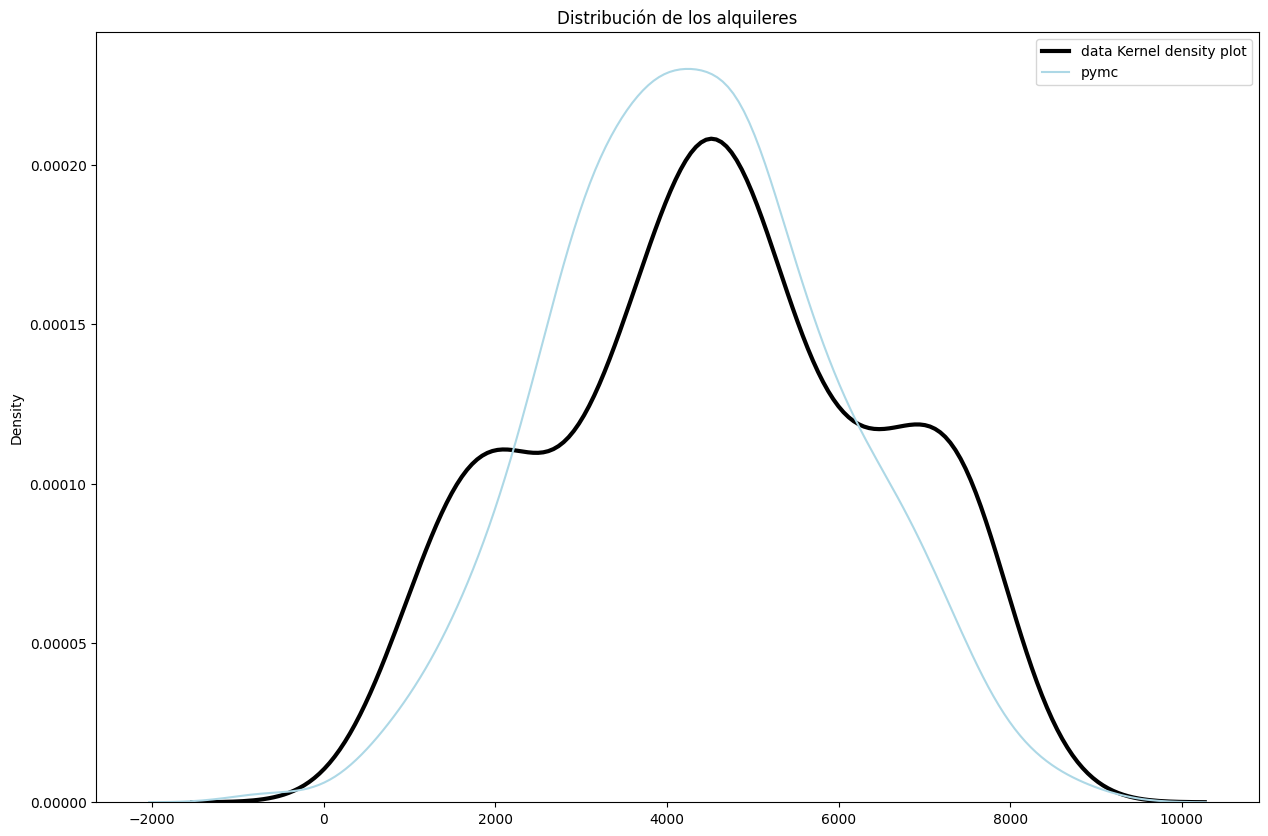



#### Ploteamos la distribucion de los alquileres de los datos vs la de los alquileres simulados para cada valor de temperatura en nuestros datos y vemos como si bien el modelo genera datos que se parecen en tendencia y spread a los originales vemos que no captura la trimodalidad que existe en los datos correctamente y nos dice que podriamos hacer un modelo mejor



In [200]:
bins = 20

plt.figure(figsize=(15, 10))

plt.title('Distribución de los alquileres')

sns.kdeplot(df_bikes.cnt.values, color = 'black', label = 'data Kernel density plot', linewidth=3)
sns.kdeplot(temperatures_predicted[:, 0] + temperatures_predicted[:, 1], color = 'lightblue', label = 'pymc')
plt.legend()
plt.show()

Markdown(fr"""

#### Ploteamos la distribucion de los alquileres de los datos vs la de los alquileres simulados para cada valor de temperatura en nuestros datos y vemos como si bien el modelo genera datos que se parecen en tendencia y spread a los originales vemos que no captura la trimodalidad que existe en los datos correctamente y nos dice que podriamos hacer un modelo mejor

""")

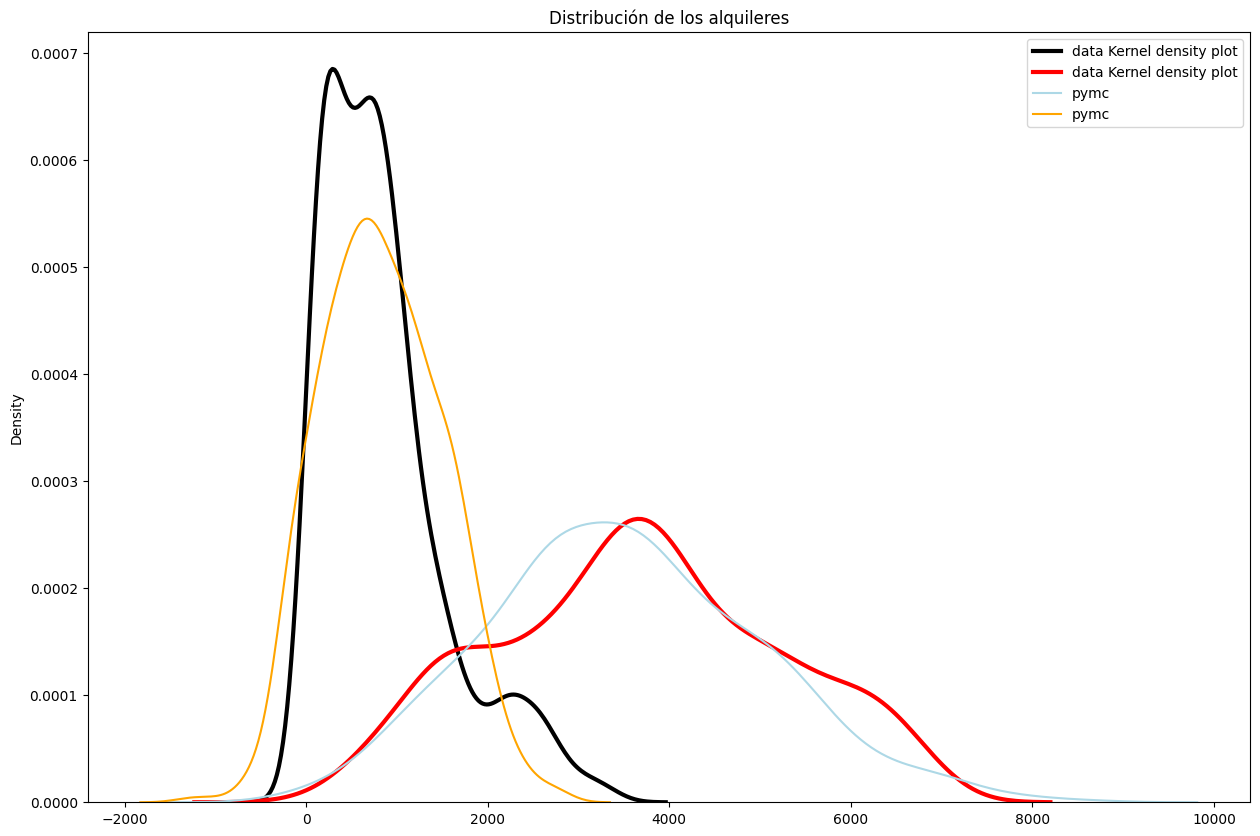

In [201]:
plt.figure(figsize=(15, 10))

plt.title('Distribución de los alquileres')

sns.kdeplot(df_bikes.casual.values, color = 'black', label = 'data Kernel density plot', linewidth=3)
sns.kdeplot(df_bikes.registered.values, color = 'red', label = 'data Kernel density plot', linewidth=3)

sns.kdeplot(temperatures_predicted[:, 0], color = 'lightblue', label = 'pymc')
sns.kdeplot(temperatures_predicted[:, 1], color = 'orange', label = 'pymc')

plt.legend()
plt.show()